Code from simba_sfc-temp-comparison.ipynb but with less exploratory plots, focused on comparing/tuning parameters for correction

Middle figures show potential for correction to minimize values >0 below surface. Good figures to replicate.

Ends with trying to create a set of functions to do the correction based on parameters but something is wrong in it. New attempt in simba_correction_MC.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
from datetime import datetime as dt
import cmocean
import datetime
from matplotlib.dates import DateFormatter
import glob
import math
from astropy.convolution import convolve
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib as mpl
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
myFmt = mdates.DateFormatter('%m-%d')

## Functions

In [2]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

In [3]:
def round_up_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return math.ceil(f / 2.) * 2

In [4]:
def round_down_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return 2 * (f // 2)

In [5]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [6]:
def calc_sw_ext(sw_sfc, kappa, depths_in, f_nir=0.5):
    """ swc_sfc is net SW from the atmosphere (SWD-SWU) 
    kappa is snow extinction coefficient, which is going to be used as a tuning parameter
    f_nir is the fraction of SW that is assumed to be NIR (as opposed to visible)
    depths is assumed to be centimeters below the surface with intervals of 2cm, i.e., 2, 4, 6 etc 
    should depths start at 0 or 2? """

    ## so that absorbed SW, clacluated as the difference between levels, covers the temperature
    # depths_in += .01

    ## transmitted SW at each level
    sw_t = f_nir*sw_sfc*np.ma.exp(-kappa*np.abs(depths_in))

    ## absorbed SW at each level
    # indexing will need to change to use SWN timeseries
    sw_a = sw_t[:,:-1] - sw_t[:,1:]

    sfc_sw_a = sw_sfc[:,0]-sw_t[:,1]

    sw_a = np.concatenate((sfc_sw_a[:, np.newaxis], sw_a), axis=1)
    
    return sw_a, sw_t

In [7]:
def calc_sw_ext_only_expon(sw_sfc, kappa, depths_in, f_nir=0.5):
    """ swc_sfc is net SW from the atmosphere (SWD-SWU) 
    kappa is snow extinction coefficient, which is going to be used as a tuning parameter
    f_nir is the fraction of SW that is assumed to be NIR (as opposed to visible)
    depths is assumed to be centimeters below the surface with intervals of 2cm, i.e., 2, 4, 6 etc 
    should depths start at 0 or 2? """

    ## so that absorbed SW, clacluated as the difference between levels, covers the temperature
    # depths_in += .01

    ## transmitted SW at each level
    sw_t = f_nir*sw_sfc*np.ma.exp(-kappa*abs(depths_in))

    ## absorbed SW at each level
    # indexing will need to change to use SWN timeseries
    sw_a = sw_t[:,:-1] - sw_t[:,1:]

    sfc_sw_a = sw_sfc[:,0]-sw_t[:,1]

    sw_a = np.concatenate((sfc_sw_a[:, np.newaxis], sw_a), axis=1)
    
    return sw_a, sw_t

In [8]:
def get_percentile_bin_vals(x_in, y_in, bins_in):
    bins_xs = []
    bins_ys = []
    
    for b0, b1 in zip(bins_in[:-1], bins_in[1:]):
        bin_idx = np.where((x_in>=b0)&(x_in<b1))[0]
        # get median of upper quartile (check impact of that choice)

        y_in_bin = y_in[bin_idx]
        
        bins_xs.append( np.mean([b0,b1]) )
        
        if y_in_bin.shape[0]<1:
            bins_ys.append(np.nan)
            # print(x_in_bin.shape)
            continue
            
        bin_upper_quart_val = np.percentile(y_in_bin[~y_in_bin.mask], 90)
        bin_upper_quart_idx = np.ma.where(y_in_bin>=bin_upper_quart_val)
        
        # bin_xs.append( np.ma.median(all_subsfc_swabs_above[bin_idx]) )
        # bins_xs.append( np.mean([b0,b1]) )
        # print(x_in_bin.shape)
        bin_med = np.ma.median(y_in_bin[bin_upper_quart_idx])
        bins_ys.append(bin_med)
    
    bins_xs = np.ma.masked_invalid(bins_xs)
    bins_ys = np.ma.masked_invalid(bins_ys)
    
    return bins_xs, bins_ys

In [9]:
def get_max_bin_vals(x_in, y_in, bins_in):
    bins_xs = []
    bins_ys = []
    
    # for b0, b1 in zip(percentiles[:-1], percentiles[1:]):
    for b0, b1 in zip(bins_in[:-1], bins_in[1:]):
        bin_idx = np.where((x_in>=b0)&(x_in<b1))[0]
        # bin_xs.append( np.ma.median(all_subsfc_swabs_above[bin_idx]) )
        bins_xs.append( np.mean([b0,b1]) )
        if len(bin_idx)<1:
            bins_ys.append(np.nan)
        else:
            bin_max = y_in[bin_idx].max()
            bins_ys.append(bin_max)
    
    bins_xs = np.ma.masked_invalid(bins_xs)
    bins_ys = np.ma.masked_invalid(bins_ys)
    
    return bins_xs, bins_ys

In [10]:
## write a new function that uses wind information to correct temperature
## should input of function include dictionary with splines???
## uchange key to include ranges?

def cal_temp_correct_ws(sw_in, ws_in, spline_parameters):
    # spline_parameters has keys that are maximum winds: 5,10,25 (what is actual maximum wind speed in the data?)

    ## calculate temperature bias for all wind intervals
    corrections = {}
    for w in spline_parameters:
        w_spline = interpolate.BSpline(spline_parameters[w][0], spline_parameters[w][1], spline_parameters[w][2],)# extrapolate=False)
        w_correction = w_spline(sw_in)
        corrections[w] = w_correction

    # mid_correction = wind_based_corrections[10](sw_in)
    # hi_correction = wind_based_corrections[25](sw_in)

    ## only use corrections for each wind interval
    temp_correction_out = np.zeros(sw_in.shape)
    temp_correction_out[np.where(ws_in<5)] = corrections[5][np.where(ws_in<5)]
    temp_correction_out[np.where((ws_in>=5)&(ws_in<10))] = corrections[10][np.where((ws_in>=5)&(ws_in<10))]
    temp_correction_out[np.where(ws_in>=10)] = corrections[25][np.where(ws_in>=10)]

    return temp_correction_out

## Load data

SIMBA specific data

In [11]:
simba_filepath = '/psd3data/arctic/raven/simba/level1/'
lev1_files = glob.glob(simba_filepath+'*.nc')
lev1_files.sort()

## on our server the simba files include some days from march during testing; this gets rid of those files
lev1_files = lev1_files[5:]

## these are the only variables I've used so far from the SIMBA
varnames = ['temperature','height','time']

season_data = {}

for fname in lev1_files[:]:
    fdic = load_netcdf(fname, varnames)

    fstart_time = dt.strptime(fdic['time_unit'][-19:], '%Y-%m-%d %H:%M:%S')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])

    for var in ['temperature','dates']:
        if var not in season_data:
            season_data[var] = fdic[var]
        else:
            season_data[var] = np.ma.concatenate( (season_data[var], fdic[var]), axis=0 )

    ## only want one height:
    if 'height' not in season_data:
        season_data['height'] = fdic['height']
        

In [12]:
with np.load('/home/asledd/ICECAPS/Raven_SIMBA_sfc-id_max-T-grad.npz') as npz:
    simba_sfc_heights = np.ma.MaskedArray(**npz)

## I know this has 15 minute time steps, so average over several hours
kernel_avg_hrs= [1./(4*6+1)]*(4*6+1)

simba_sfc = convolve(simba_sfc_heights, kernel_avg_hrs, boundary='extend')
# simba_sfc = np.ma.masked_invalid([round_up_to_even(height) for height in simba_sfc])

simba_sfc = np.ma.masked_invalid([round_up_to_even(height) for height in simba_sfc]) ## can also do round_down_to_even()

## this was a day with quick accumulation that gets unrealistically smoothed in the surface height
simba_sfc = np.ma.masked_where((season_data['dates']>=dt(2024,6, 25))&(season_data['dates']<dt(2024,6, 26)), simba_sfc)
# print(simba_sfc)
simba_sfc -= 6.
simba_sfc_heights -= 6.
print(simba_sfc)

# simba_sfc_dn = np.ma.masked_where((season_data['dates']>=dt(2024,6, 25))&(season_data['dates']<dt(2024,6, 26)), simba_sfc_dn)

[-- -- -- ... -348.0 -348.0 -348.0]


Load SLEIGH and related data (corrected skin temperature, winds)

In [13]:
# turn into function later
asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/'
asfs_lev2_files = glob.glob(asfs_filepath+'seb.level2.0.melt-sleighsfs.10min.*.nc')
asfs_lev2_files.sort()
# asfs_lev2_files = asfs_lev2_files[12:] # early files don't have skin_temp_surface?

# vaisala_T_Avg = average of the air temperature during the 1 min averaging interval

lev1_slow_vars = ['up_short_hemisp_qc','up_long_hemisp_qc','down_short_hemisp_qc','down_long_hemisp_qc','subsurface_heat_flux_A_qc',
                  'subsurface_heat_flux_B_qc','skin_temp_surface_qc','temp_qc','snow_depth_qc','zenith_true_qc',
                  'down_short_diffuse','down_short_direct','up_short_hemisp','up_long_hemisp','down_short_hemisp','down_long_hemisp',
                  'snow_depth','temp','brightness_temp_surface','skin_temp_surface','subsurface_heat_flux_A','subsurface_heat_flux_B',
                  'subsurface_heat_flux_C','zenith_true','base_time','time']

asfs_data_lev2 = {}

for fname in asfs_lev2_files[:]:
    print(fname)

    fdic = load_netcdf(fname, lev1_slow_vars)
    # print(fdic['time_unit'])
    fstart_time = dt.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(seconds=int(m)) for m in fdic['time']])

    for var in lev1_slow_vars[:-2]+['dates']:
        if var not in asfs_data_lev2:
            asfs_data_lev2[var] = fdic[var]
        else:
            asfs_data_lev2[var] = np.ma.concatenate( (asfs_data_lev2[var], fdic[var]), axis=0 )
asfs_data_lev2['net_short_hemisp'] = asfs_data_lev2['down_short_hemisp'] - asfs_data_lev2['up_short_hemisp']
asfs_data_lev2['albedo'] =  asfs_data_lev2['up_short_hemisp']/asfs_data_lev2['down_short_hemisp']

/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240520.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240521.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240522.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240523.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240524.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240525.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240526.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240527.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240528.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb

In [14]:
# with np.load('/home/asledd/ICECAPS/Raven_SW-correct-tskin_emis985_20250107.npz') as npz:
#     sleigh_tskin_pos = np.ma.MaskedArray(**npz)
with np.load('/home/asledd/ICECAPS/Raven_SW-correct-tskin_emis985_all-times_20250113.npz') as npz:
    asfs_data_lev2['skin_temp'] = np.ma.MaskedArray(**npz)

In [15]:
data = np.genfromtxt('/home/asledd/ICECAPS/preliminary_raven_winds_icecaps_2024May20th_2024July23rd.csv', delimiter=',',
                         usecols=(0,5), dtype=None, encoding='utf-8')
raw_wind_spd = np.array(data[1:,1])
raw_wind_spd[np.where(raw_wind_spd=='')] = '-999'
raw_wind_spd = raw_wind_spd.astype(np.float32)

raw_wind_dates = np.asarray([dt.strptime(d, '%Y-%m-%d %H:%M:%S') for d in data[1:,0]])


In [16]:
## It's annoying to have the winds with different time steps, make it match the sleigh dates

wind_spd = []

for date in asfs_data_lev2['dates']:
    
    if date in raw_wind_dates:
        wind_spd.append(raw_wind_spd[np.where(date==raw_wind_dates)[0]][0])
    else:
        wind_spd.append(-999)

wind_spd = np.ma.masked_equal(wind_spd, -999)

#### interpolate SLEIGH data to SIMBA timesteps

In [17]:
simba_dates = season_data['dates']
simba_depths = season_data['height']

sleigh_dates = asfs_data_lev2['dates']

In [18]:
# Interpolate SWN to have same timesteps as SIMBA data

sleigh_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in sleigh_dates])
simba_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in simba_dates])

swn = asfs_data_lev2['net_short_hemisp']
f_0 = interpolate.interp1d(sleigh_seconds[~swn.mask], swn[~swn.mask], fill_value=-999, bounds_error=False)
simba_swn = f_0(simba_seconds)
simba_swn = np.ma.masked_equal(simba_swn, -999)

f_0 = interpolate.interp1d(sleigh_seconds[~wind_spd.mask], wind_spd[~wind_spd.mask], fill_value=-999, bounds_error=False)
simba_wspd = f_0(simba_seconds)
simba_wspd = np.ma.masked_equal(simba_wspd, -999)

# sleigh_skin = asfs_data_lev2['skin_temp']
# f_0_skinT = interpolate.interp1d(sleigh_seconds[~sleigh_skin.mask], sleigh_skin[~sleigh_skin.mask], fill_value=-999, bounds_error=False)
# simb_sleigh_skinT = f_0_skinT(simba_seconds)
# simb_sleigh_skinT = np.ma.masked_equal(simb_sleigh_skinT, -999)


#### also make some 2D arrays that can be used with depths to calculate correction

In [19]:
dpths = np.arange(0,.50,.02)
dpths_2d = np.repeat(dpths[np.newaxis,:], simba_swn.shape[0], axis=0)
simba_swn_2d = np.repeat(simba_swn[:,np.newaxis], dpths.shape[0], axis=1)

# ignore negative values for now????
simba_swn_2d = np.ma.masked_less(simba_swn_2d, 0)

simba_wspd_2d = np.repeat(simba_wspd[:,np.newaxis], dpths.shape[0], axis=1)

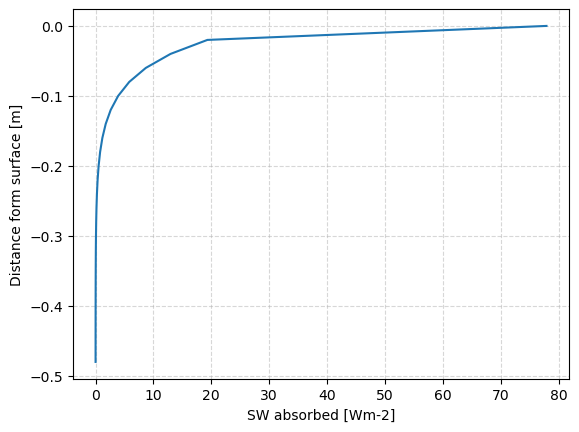

In [20]:
ks_vis = 20.
nir_frac = 0.5

# ks_st = 30.
# ks_en = 15.
# ks_vis = np.linspace(ks_st, ks_en, simba_swn_2d.shape[0])[:,np.newaxis]

sw_abs, sw_trans = calc_sw_ext(simba_swn_2d, ks_vis, dpths_2d, f_nir=nir_frac)
sw_abs = np.ma.masked_array(sw_abs, mask=simba_swn_2d.mask)

plt.plot(sw_abs[1020,:], -dpths_2d[0,:])
plt.ylabel('Distance form surface [m]')
plt.xlabel('SW absorbed [Wm-2]')
plt.grid(ls='--', alpha=.5)
plt.show()


## Get correction functions based on SW and wind speed

### Select times and depths where skin temperature is ~0 and SIMBA temperatures are >=0

In [21]:
## get same time intervals
sleigh_idx = np.where((sleigh_dates>dt(2024,6,1))&(sleigh_dates<dt(2024,7,21)))[0]
imb_idx = np.where((simba_dates>dt(2024,6,1))&(simba_dates<dt(2024,7,21)))[0]

## get overlapping dates
same_idx_sleigh = np.intersect1d(sleigh_dates[sleigh_idx], simba_dates[imb_idx], return_indices=True)[1]
same_idx_simba = np.intersect1d(simba_dates[imb_idx], sleigh_dates[sleigh_idx], return_indices=True)[1]

## get times when skin temperature is melting (within uncertainty)
melt_idx = np.where(asfs_data_lev2['skin_temp'][sleigh_idx][same_idx_sleigh]>=(273.15-.3))[0]

In [22]:
## melt_idx was defined several cells above when comparing surface/skin temperature from SIMBA and SLEIGH

# for idx in melt_idx[:]:
for idx in range(len(same_idx_simba)):
    example_profile = season_data['temperature'][imb_idx,:][same_idx_simba,:][idx,:]

    idx_sfc = simba_sfc_heights[imb_idx][same_idx_simba][idx]
    subsfc_idx = np.where(simba_depths[:-1]<=idx_sfc)[0] ## HERE changed [:-1] to [1:]
    example_profile = np.squeeze(example_profile[subsfc_idx])
    too_warm_idx = np.where(example_profile>0)[0]

    sw_abs_warm = sw_trans[imb_idx,:][same_idx_simba,:][idx,:][too_warm_idx]

    wspd_warm = simba_wspd_2d[imb_idx,:][same_idx_simba,:][idx,:][too_warm_idx]
    
    # sw_abs_warm = sw_abs[imb_idx,:][same_idx_simba,:][idx,:][too_warm_idx]
    temp_warm = example_profile[too_warm_idx]

    ## still removing surface value
    # if idx==melt_idx[0]:
    if idx==0:
        all_subsfc_temps_above = temp_warm[1:]
        all_subsfc_swabs_above = sw_abs_warm[1:]
        all_subsfc_depths = simba_depths[:-1][subsfc_idx][too_warm_idx][1:]+abs(idx_sfc)
        all_subsfc_wspd = wspd_warm[1:]
    else:
        all_subsfc_temps_above = np.ma.concatenate((all_subsfc_temps_above, temp_warm[1:]))
        all_subsfc_swabs_above = np.ma.concatenate((all_subsfc_swabs_above, sw_abs_warm[1:]))
        all_subsfc_depths = np.ma.concatenate((all_subsfc_depths, simba_depths[:-1][subsfc_idx][too_warm_idx][1:]+abs(idx_sfc)))
        all_subsfc_wspd = np.ma.concatenate((all_subsfc_wspd, wspd_warm[:-1]))

### Now actually plot temperature vs SW to calculate correction functions

In [23]:
def logFit(x,y):
    # cache some frequently reused terms
    # from https://stackoverflow.com/questions/49944018/fit-a-logarithmic-curve-to-data-points-and-extrapolate-out-in-numpy
    sumy = np.sum(y)
    sumlogx = np.sum(np.log(x))

    b = (x.size*np.sum(y*np.log(x)) - sumy*sumlogx)/(x.size*np.sum(np.log(x)**2) - sumlogx**2)
    a = (sumy - b*sumlogx)/x.size

    return a,b

def logFunc(x, a, b):
    return a + b*np.log(x)

In [24]:
def inverse_hyperbolic_sine(x, theta):
    return np.arcsinh(x / theta)

In [25]:
def tanh_function(x, amplitude, x_0, frequency):
    return amplitude * np.tanh(frequency * (x - x_0))

In [26]:
def func(x, a, b):
  # return 1 - 1/(1 + a*x)
  return b*(x / (a + x))


In [27]:
## effectiveness of bins depends on extinction coefficient

sw_bin_params = {'width0':{15:1, 20:2, 25:1, 40:.1, 35:1, 30:1}, 'width1':{15:10, 20:10, 25:15, 40:10, 35:10, 30:10}, 
                 'midpt':{15:15, 20:15, 25:10, 40:5, 35:10, 30:10}}

/tmp/ipykernel_1313135/4184143307.py:5: RuntimeWarning: divide by zero encountered in log
  sumlogx = np.sum(np.log(x))
/tmp/ipykernel_1313135/4184143307.py:7: RuntimeWarning: divide by zero encountered in log
  b = (x.size*np.sum(y*np.log(x)) - sumy*sumlogx)/(x.size*np.sum(np.log(x)**2) - sumlogx**2)
/tmp/ipykernel_1313135/4184143307.py:5: RuntimeWarning: divide by zero encountered in log
  sumlogx = np.sum(np.log(x))
/tmp/ipykernel_1313135/4184143307.py:7: RuntimeWarning: divide by zero encountered in log
  b = (x.size*np.sum(y*np.log(x)) - sumy*sumlogx)/(x.size*np.sum(np.log(x)**2) - sumlogx**2)
/tmp/ipykernel_1313135/4184143307.py:5: RuntimeWarning: divide by zero encountered in log
  sumlogx = np.sum(np.log(x))
/tmp/ipykernel_1313135/4184143307.py:7: RuntimeWarning: divide by zero encountered in log
  b = (x.size*np.sum(y*np.log(x)) - sumy*sumlogx)/(x.size*np.sum(np.log(x)**2) - sumlogx**2)


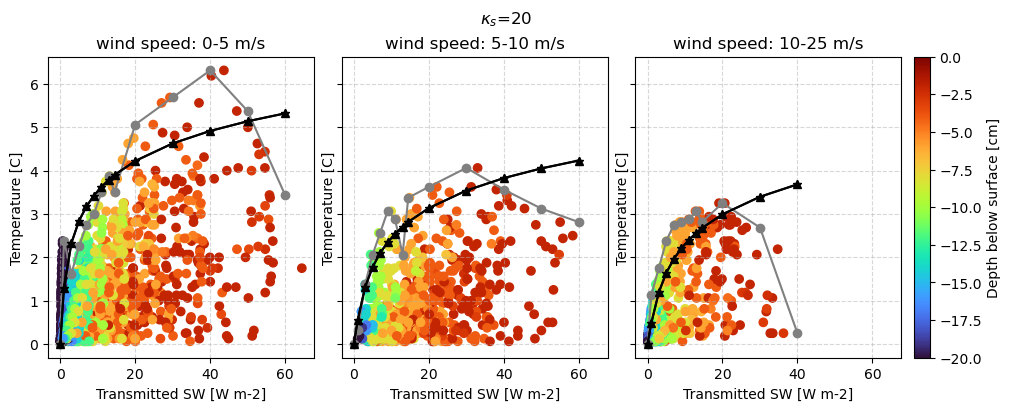

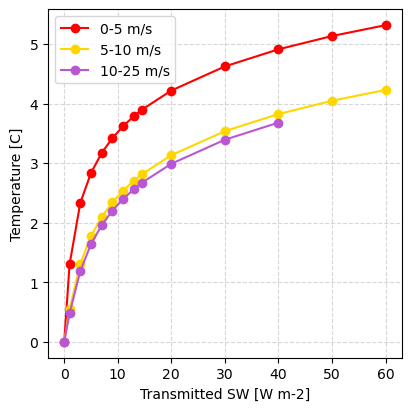

In [28]:
## melt_idx was defined several cells above when comparing surface/skin temperature from SIMBA and SLEIGH

color_list = ['r','gold','mediumorchid','skyblue']

bins = np.ma.concatenate( (np.arange(0, sw_bin_params['midpt'][ks_vis]+.01, sw_bin_params['width0'][ks_vis]), 
                           np.arange(sw_bin_params['midpt'][ks_vis], 70.01, sw_bin_params['width1'][ks_vis])) ) # bins for absorbed SW at depth

cmap = plt.cm.turbo

fig, axs = plt.subplots(1,3, figsize=(10,4), constrained_layout=True, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(1, constrained_layout=True, figsize=(4,4))

wind_ranges = [0,5,10,25]

a_vals = []
b_vals = []
max_wspd = []

ihs_vals = []

func_vals_a = []
func_vals_b = []

## save splines for future use as corrections - better way to save?
wind_based_corrections = {}

for i,(w_lo, w_hi, ax) in enumerate(zip(wind_ranges[:-1],wind_ranges[1:], axs.ravel())):

    w_idx = np.where((all_subsfc_wspd>=w_lo)&(all_subsfc_wspd<w_hi))
    sw_wind = all_subsfc_swabs_above[w_idx]
    temp_wind = all_subsfc_temps_above[w_idx]
    
    cb = ax.scatter(sw_wind, temp_wind, 
                    c=all_subsfc_depths[w_idx], vmin=-20, vmax=0, cmap=cmap)

    ## try adding curve using splines
    ## had also used get_max_bin_vals(sw_wind, temp_wind, bins) in original test
    # bin_xs, bin_ys = get_percentile_bin_vals(sw_wind, temp_wind, bins)
    bin_xs, bin_ys = get_max_bin_vals(sw_wind, temp_wind, bins)

    ## force (0,0) point
    bin_xs = np.ma.concatenate( ([0],bin_xs) )
    bin_ys = np.ma.concatenate( ([0],bin_ys) )

    ax.plot(bin_xs, bin_ys, c='gray', marker='o')

    bin_xs = np.squeeze(bin_xs[~bin_ys.mask])
    bin_ys = np.squeeze(bin_ys[~bin_ys.mask])
                        
    t, c, k = interpolate.splrep(bin_xs, bin_ys, s=10, k=3)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    # wind_based_corrections[w_hi] = spline
    wind_based_corrections[w_hi] = (t, c, k)
    
    # ax.plot(bin_xs, spline(bin_xs), c='k', marker='^')

    # ax2.plot(bin_xs, spline(bin_xs), marker='o', label='{:.0f}-{:.0f} m/s'.format(w_lo, w_hi), c=color_list[i])


    # trying log fit
    range_a, range_b = logFit(bin_xs,bin_ys)
    a_vals.append(range_a)
    b_vals.append(range_b)
    max_wspd.append(w_lo)

    # ax.plot(bin_xs, logFunc(bin_xs, *logFit(bin_xs,bin_ys)), c='k', marker='*')
    # ax2.plot(bin_xs, logFunc(bin_xs, *logFit(bin_xs,bin_ys)), marker='o', label='{:.0f}-{:.0f} m/s'.format(w_lo, w_hi), c=color_list[i])

    ## trying inverse hyperbolic sine
    # Fit the IHS function to the data using curve_fit
    popt, pcov = curve_fit(inverse_hyperbolic_sine, bin_xs, bin_ys)
    
    # Extract the fitted parameter
    theta_fit = popt[0]
    ihs_vals.append(theta_fit)
    
    # Generate y values from the fitted parameters
    y_fit = inverse_hyperbolic_sine(bin_xs, theta_fit)
    ax.plot(bin_xs, y_fit, c='k', marker='^')

    # # Fit the curve
    # popt, pcov = curve_fit(tanh_function, bin_xs, bin_ys, p0=[1, 0, 1])
    
    # # Extract the fitted parameters
    # amplitude_fit, x_0_fit, frequency_fit = popt
    
    # # Generate fitted curve
    # y_fit = tanh_function(bin_xs, amplitude_fit, x_0_fit, frequency_fit)
    # Fit the data to the function
    popt, pcov = curve_fit(func, bin_xs, bin_ys)
    
    # Extract the fitted parameter
    a_fit = popt[0]
    b_fit = popt[1]

    func_vals_a.append(a_fit)
    func_vals_b.append(b_fit)
    
    # Generate fitted curve
    # y_fit = func(bin_xs, a_fit, b_fit)

    ax.plot(bin_xs, y_fit, c='k', marker='*')
    ax2.plot(bin_xs, y_fit, marker='o', label='{:.0f}-{:.0f} m/s'.format(w_lo, w_hi), c=color_list[i])

    
    ax.set_title('wind speed: {:.0f}-{:.0f} m/s'.format(w_lo, w_hi))
    ax.grid(alpha=.5, ls='--')
    ax.set_xlabel('Transmitted SW [W m-2]')
    ax.set_ylabel('Temperature [C]')

plt.colorbar(cb, label='Depth below surface [cm]', ax=axs[-1])
# fig.suptitle('$\kappa_s$={:.0f}; Tskin~0'.format(ks_vis))
fig.suptitle('$\kappa_s$={:.0f}'.format(ks_vis))


ax2.grid(alpha=.5, ls='--')
ax2.set_xlabel('Transmitted SW [W m-2]')
ax2.set_ylabel('Temperature [C]')
ax2.legend(loc='best')#, bbox_to_anchor=(1.,.6))
plt.show()

max_wspd = np.asarray(max_wspd)


Can parameters of log function be calculated assuming a linear relationship with wind speed?

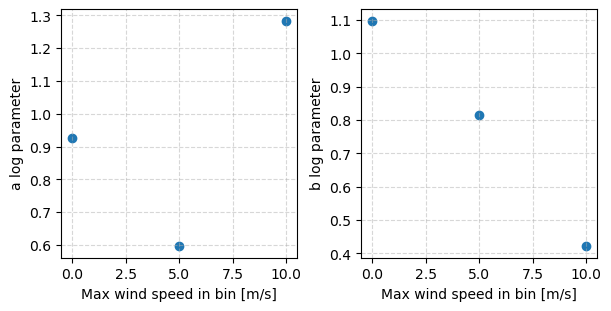

In [29]:
# a_vals = [0.8532328522045223, 0.4291125749899587, 0.02752029116252146]
# b_vals = [1.2178760059966884, 0.9932263971926361, 0.6346908159209467]
# max_wspd = [0, 5, 15]

log_param_wind_regressions = {}

fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(6,3))
labels = ['a','b']
for ax, yvals, yl in zip(axs.ravel(), [a_vals, b_vals], labels):
    ax.scatter(max_wspd, yvals)
    ax.grid(alpha=.5, ls='--')
    ax.set_xlabel('Max wind speed in bin [m/s]')
    ax.set_ylabel(yl+' log parameter')

    # save for later
    par = np.polyfit(max_wspd, yvals, 1, full=True)
    log_param_wind_regressions[yl] = {'slope':par[0][0], 'intercept':par[0][1]}
    

plt.show()

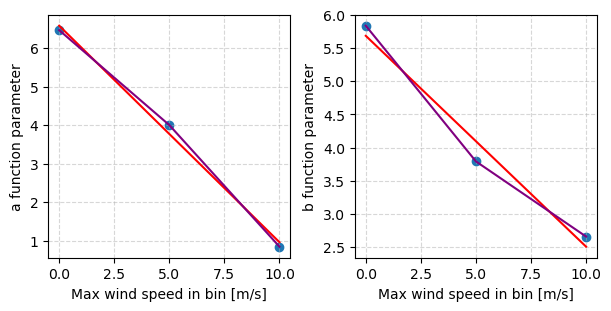

In [30]:
# a_vals = [0.8532328522045223, 0.4291125749899587, 0.02752029116252146]
# b_vals = [1.2178760059966884, 0.9932263971926361, 0.6346908159209467]
# max_wspd = [0, 5, 15]

func_param_wind_regressions = {}

fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(6,3))
labels = ['a','b']
for ax, yvals, yl in zip(axs.ravel(), [func_vals_a, func_vals_b], labels):
    ax.scatter(max_wspd, yvals)
    ax.grid(alpha=.5, ls='--')
    ax.set_xlabel('Max wind speed in bin [m/s]')
    ax.set_ylabel(yl+' function parameter')

    # save for later
    par = np.polyfit(max_wspd, yvals, 1, full=True)
    func_param_wind_regressions[yl] = {'slope':par[0][0], 'intercept':par[0][1]}

    t, c, k = interpolate.splrep(max_wspd, yvals, k=2)
    spline = interpolate.BSpline(t, c, k, extrapolate=True)
    func_param_wind_regressions[yl]['spline'] = spline

    ax.plot(max_wspd, par[0][0]*max_wspd+par[0][1], c='r')

    ax.plot(max_wspd, spline(max_wspd), c='purple')

plt.show()

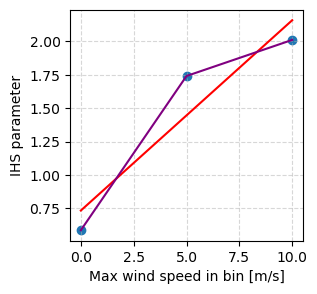

In [31]:
# a_vals = [0.8532328522045223, 0.4291125749899587, 0.02752029116252146]
# b_vals = [1.2178760059966884, 0.9932263971926361, 0.6346908159209467]
# max_wspd = [0, 5, 15]

ihs_param_wind_regressions = {}

# save for later
par = np.polyfit(max_wspd, ihs_vals, 1, full=True)
ihs_param_wind_regressions['slope'] = par[0][0]
ihs_param_wind_regressions['intercept'] = par[0][1]

## does spline do better?
t, c, k = interpolate.splrep(max_wspd, ihs_vals, k=1)
spline = interpolate.BSpline(t, c, k, extrapolate=True)
ihs_param_wind_regressions['spline'] = spline

fig, ax = plt.subplots(1, figsize=(3,3))

ax.scatter(max_wspd, ihs_vals)
ax.grid(alpha=.5, ls='--')
ax.set_xlabel('Max wind speed in bin [m/s]')
ax.set_ylabel('IHS parameter')
plt.plot(max_wspd, par[0][0]*max_wspd+par[0][1], c='r')
ax.plot(max_wspd, spline(max_wspd), c='purple')

plt.show()

/tmp/ipykernel_1313135/4184143307.py:13: RuntimeWarning: divide by zero encountered in log
  return a + b*np.log(x)
/tmp/ipykernel_1313135/4184143307.py:13: RuntimeWarning: divide by zero encountered in log
  return a + b*np.log(x)
/tmp/ipykernel_1313135/4184143307.py:13: RuntimeWarning: divide by zero encountered in log
  return a + b*np.log(x)
/tmp/ipykernel_1313135/4184143307.py:13: RuntimeWarning: divide by zero encountered in log
  return a + b*np.log(x)
/tmp/ipykernel_1313135/4184143307.py:13: RuntimeWarning: divide by zero encountered in log
  return a + b*np.log(x)
/tmp/ipykernel_1313135/4184143307.py:13: RuntimeWarning: divide by zero encountered in log
  return a + b*np.log(x)
/tmp/ipykernel_1313135/4184143307.py:13: RuntimeWarning: divide by zero encountered in log
  return a + b*np.log(x)
/tmp/ipykernel_1313135/4184143307.py:13: RuntimeWarning: divide by zero encountered in log
  return a + b*np.log(x)
/tmp/ipykernel_1313135/4184143307.py:13: RuntimeWarning: divide by zero 

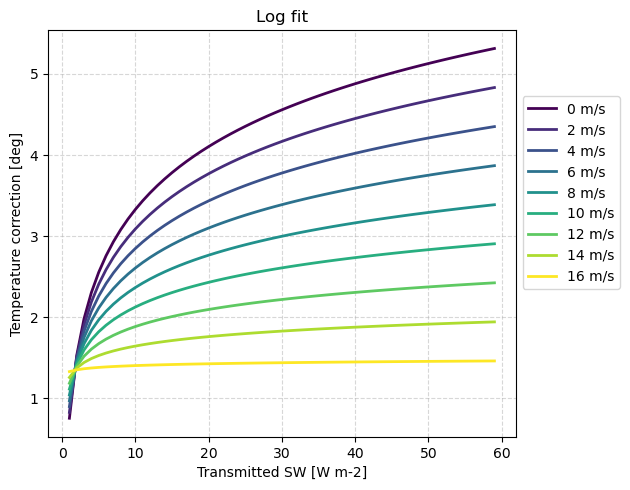

In [32]:
exmaple_sw = np.arange(0,60)

for wspd in range (0,18,2):
    log_a = log_param_wind_regressions['a']['slope']*wspd+log_param_wind_regressions['a']['intercept']
    log_b = log_param_wind_regressions['b']['slope']*wspd+log_param_wind_regressions['b']['intercept']

    col = plt.cm.viridis(wspd/16.)
    plt.plot(exmaple_sw, logFunc(exmaple_sw, log_a, log_b), label='{:.0f} m/s'.format(wspd), c=col, lw=2)

plt.legend(loc='center left', bbox_to_anchor=(1,.6))
plt.grid(alpha=.5, ls='--')
plt.xlabel('Transmitted SW [W m-2]')
plt.ylabel('Temperature correction [deg]')
plt.tight_layout()
plt.title('Log fit')
plt.show()

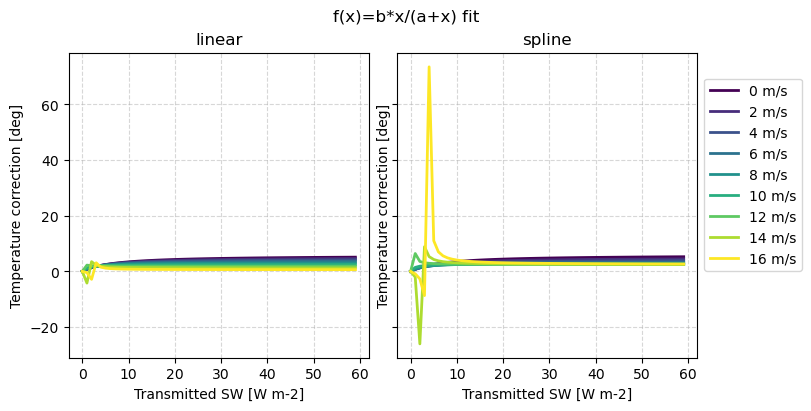

In [33]:
exmaple_sw = np.arange(0,60)

fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True, sharey=True)


for wspd in range (0,18,2):
    log_a = func_param_wind_regressions['a']['slope']*wspd+func_param_wind_regressions['a']['intercept']
    log_b = func_param_wind_regressions['b']['slope']*wspd+func_param_wind_regressions['b']['intercept']

    col = plt.cm.viridis(wspd/16.)
    axs[0].plot(exmaple_sw, func(exmaple_sw, log_a, log_b), label='{:.0f} m/s'.format(wspd), c=col, lw=2)


    # spline fit for theta parameters
    par_a = func_param_wind_regressions['a']['spline'](wspd)
    par_b = func_param_wind_regressions['b']['spline'](wspd)

    col = plt.cm.viridis(wspd/16.)
    # axs[1].plot(exmaple_sw, np.abs(inverse_hyperbolic_sine(exmaple_sw, theta)), label='{:.0f} m/s'.format(wspd), c=col, lw=2)
    axs[1].plot(exmaple_sw, func(exmaple_sw, par_a, par_b), label='{:.0f} m/s'.format(wspd), c=col, lw=2)


axs[1].legend(loc='center left', bbox_to_anchor=(1,.6))

for ax, fit in zip(axs.ravel(),['linear', 'spline']):
    # ax.set_ylim(0,5.5)
    ax.grid(alpha=.5, ls='--')
    ax.set_xlabel('Transmitted SW [W m-2]')
    ax.set_ylabel('Temperature correction [deg]')
    ax.set_title(fit)
    
# plt.tight_layout()
fig.suptitle('f(x)=b*x/(a+x) fit')
plt.show()

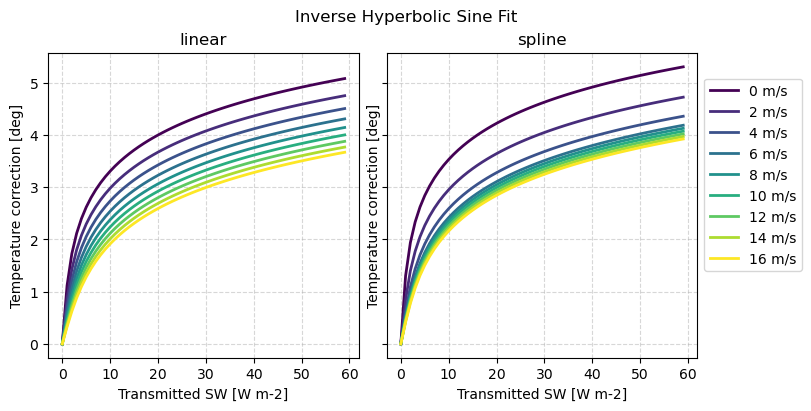

In [34]:
exmaple_sw = np.arange(0,60)

fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True, sharey=True)

for wspd in range (0,18,2):
    
    # lienar fit for theta parameters
    theta = ihs_param_wind_regressions['slope']*wspd+ihs_param_wind_regressions['intercept']  
    # print(wspd, theta)
    col = plt.cm.viridis(wspd/16.)
    axs[0].plot(exmaple_sw, np.abs(inverse_hyperbolic_sine(exmaple_sw, theta)), label='{:.0f} m/s'.format(wspd), c=col, lw=2)

    # spline fit for theta parameters
    theta = ihs_param_wind_regressions['spline'](wspd)
    # print(theta)
    # print()
    col = plt.cm.viridis(wspd/16.)
    axs[1].plot(exmaple_sw, np.abs(inverse_hyperbolic_sine(exmaple_sw, theta)), label='{:.0f} m/s'.format(wspd), c=col, lw=2)
    
## how to remove negative output???


axs[1].legend(loc='center left', bbox_to_anchor=(1,.6))

for ax, fit in zip(axs.ravel(),['linear', 'spline']):
    # ax.set_ylim(0,5.5)
    ax.grid(alpha=.5, ls='--')
    ax.set_xlabel('Transmitted SW [W m-2]')
    ax.set_ylabel('Temperature correction [deg]')
    ax.set_title(fit)
    
fig.suptitle('Inverse Hyperbolic Sine Fit')
# plt.tight_layout()
plt.show()

## Now go through getting temperature corrections at real depths for SIMBA

### Get all the 2D arrays in order

In [35]:
# make simba heights/depths relative to surface
depths_rel_to_sfc = np.repeat(simba_depths[np.newaxis,:], simba_dates.shape[0], axis=0)
sfc_height_2d = np.repeat(simba_sfc[:,np.newaxis], simba_depths.shape[0], axis=1)

depths_rel_to_sfc = depths_rel_to_sfc+ abs(sfc_height_2d)
depths_rel_to_sfc = np.ma.masked_greater(depths_rel_to_sfc, 0)/100.

In [36]:
## using SWN array from above
# ks_vis = 20. use ks_vis from above so that correction is consistent with the functions!!!
simba_swn_2d = np.repeat(simba_swn[:,np.newaxis], depths_rel_to_sfc.shape[1], axis=1)
simba_swa, simba_swt = calc_sw_ext(simba_swn_2d, ks_vis, depths_rel_to_sfc, f_nir=.5)
simba_swa = np.ma.masked_array(simba_swa, mask=depths_rel_to_sfc.mask)
simba_swt = np.ma.masked_array(simba_swt, mask=depths_rel_to_sfc.mask)


In [37]:
wspd_2d_full = np.repeat(simba_wspd[:,np.newaxis], simba_swn_2d.shape[1], axis=1)
wspd_2d_full = np.ma.masked_array(wspd_2d_full, mask=depths_rel_to_sfc.mask)

Plot all the relevant variables that are involved in the correction

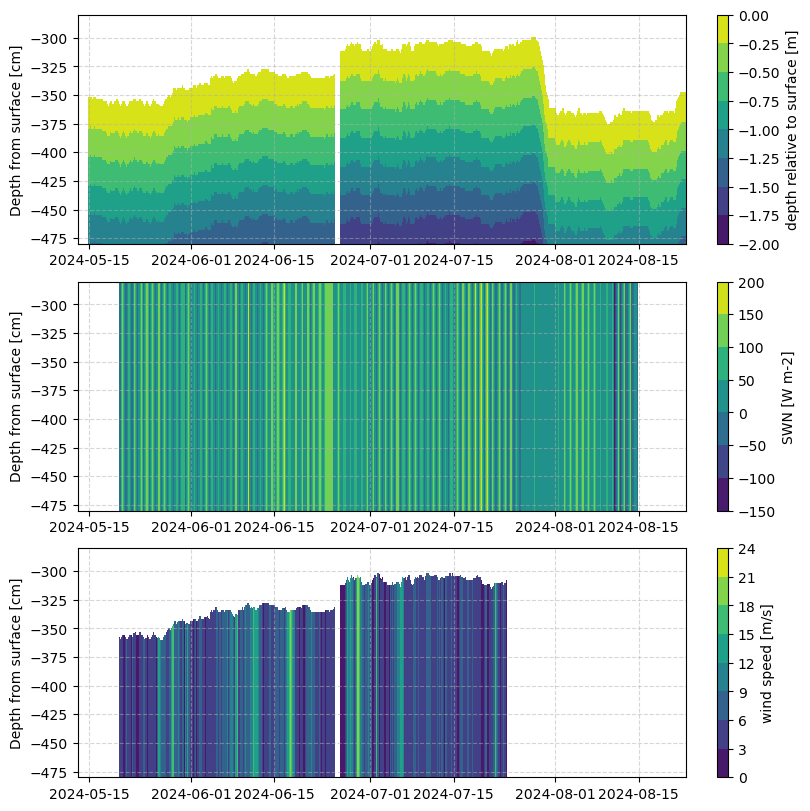

In [38]:
fig, axs = plt.subplots(3, figsize=(8,8), constrained_layout=True, sharey=True)
cb = axs[0].contourf(simba_dates, simba_depths, np.swapaxes(depths_rel_to_sfc,0,1))#, levels=np.linspace(0,20,11), extend='max')
plt.colorbar(cb, label='depth relative to surface [m]', ax=axs[0])

cb = axs[1].contourf(simba_dates, simba_depths, np.swapaxes(simba_swn_2d,0,1))#, levels=np.linspace(0,20,11), extend='max')
plt.colorbar(cb, label='SWN [W m-2]', ax=axs[1])

cb = axs[2].contourf(simba_dates, simba_depths, np.swapaxes(wspd_2d_full,0,1))#, levels=np.linspace(0,20,11), extend='max')
plt.colorbar(cb, label='wind speed [m/s]', ax=axs[2])

for ax in axs.ravel():
    ax.set_ylabel('Depth from surface [cm]')
    ax.grid(alpha=.5, ls='--')

axs[0].set_ylim(-480,-280)
plt.show()

## Actual correction calculation and results

In [39]:
def calc_log_temp_correct(sw_in, wspd_in, log_param_from_wind):
    
    log_a = log_param_from_wind['a']['slope']*wspd_in + log_param_from_wind['a']['intercept']
    log_b = log_param_from_wind['b']['slope']*wspd_in + log_param_from_wind['b']['intercept']

    temp_corrs = logFunc(sw_in, log_a, log_b)
             
    return temp_corrs

In [40]:
def calc_ihs_temp_correct(sw_in, wspd_in, ihs_param_from_wind, fit='spline'):

    if fit=='linear':
        theta = ihs_param_from_wind['slope']*wspd_in+ihs_param_from_wind['intercept']
    elif fit=='spline':
        theta = ihs_param_from_wind['spline'](wspd_in)
        
    temp_corrs = abs(inverse_hyperbolic_sine(sw_in, theta))

    
    return temp_corrs

In [41]:
def calc_func_temp_correct(sw_in, wspd_in, ihs_param_from_wind, fit='spline'):

    
    if fit=='linear':
        par_a = func_param_wind_regressions['a']['slope']*wspd_in + func_param_wind_regressions['a']['intercept']
        par_b = func_param_wind_regressions['b']['slope']*wspd_in + func_param_wind_regressions['b']['intercept']
    elif fit=='spline':
        par_a = func_param_wind_regressions['a']['spline'](wspd_in)
        par_b = func_param_wind_regressions['b']['spline'](wspd_in)

    temp_corrs = func(sw_in, par_a, par_b)

    
    return temp_corrs

In [42]:
ws_temp_correction = cal_temp_correct_ws(simba_swt, wspd_2d_full, wind_based_corrections)
ws_temp_correction = np.ma.masked_array(ws_temp_correction, mask=simba_swt.mask, fill_value=0.)

In [43]:
log_temp_correction = calc_log_temp_correct(simba_swt, wspd_2d_full, log_param_wind_regressions)
log_temp_correction = np.ma.masked_where(simba_swt<1, log_temp_correction)

log_temp_correction[log_temp_correction.mask] = 0

/tmp/ipykernel_1313135/4184143307.py:13: RuntimeWarning: divide by zero encountered in log
  return a + b*np.log(x)
/tmp/ipykernel_1313135/4184143307.py:13: RuntimeWarning: invalid value encountered in log
  return a + b*np.log(x)


In [44]:
ihs_temp_correction = calc_ihs_temp_correct(simba_swt, wspd_2d_full, ihs_param_wind_regressions)


In [45]:
func_temp_correction = calc_func_temp_correct(simba_swt, wspd_2d_full, func_param_wind_regressions, fit='spline')


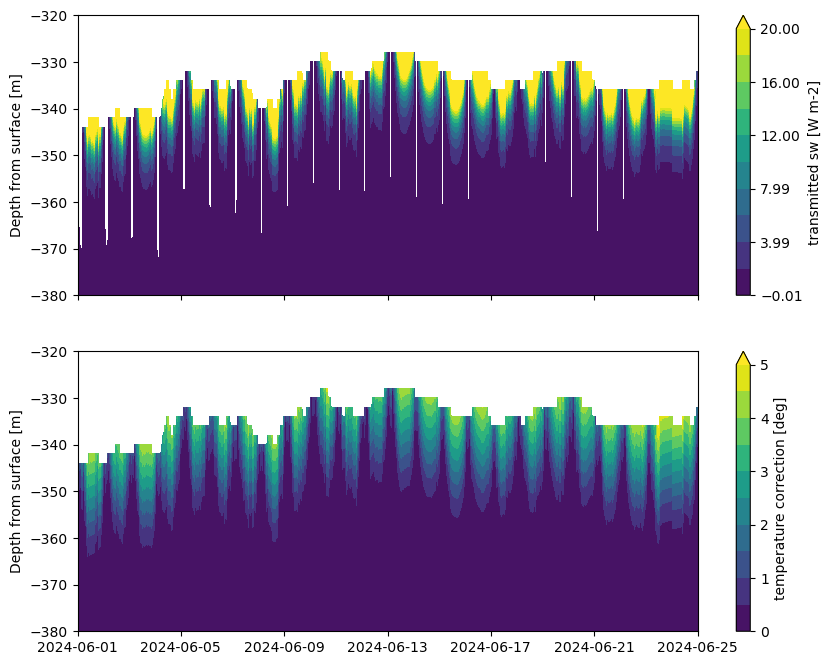

In [46]:
fig, axs = plt.subplots(2, figsize=(10,8), sharex=True, sharey=True)
cb = axs[0].contourf(simba_dates, simba_depths, np.swapaxes(simba_swt,0,1), levels=np.linspace(-.01,20,11), extend='max')
plt.colorbar(cb, label='transmitted sw [W m-2]', ax=axs[0])
axs[0].set_ylabel('Depth from surface [m]')

cb = axs[1].contourf(simba_dates, simba_depths, np.swapaxes(ihs_temp_correction,0,1), levels=np.arange(0,5.01,.5), extend='max')
plt.colorbar(cb, label='temperature correction [deg]', ax=axs[1])
axs[1].set_ylabel('Depth from surface [m]')

axs[0].set_ylim(-380,-320)
axs[0].set_xlim(dt(2024,6,1),dt(2024,6,25))
plt.show()

### What do corrected temperatures look like?

In [47]:
# corrected_temps = season_data['temperature'] - ws_temp_correction
# corrected_temps = season_data['temperature'] - log_temp_correction
corrected_temps = season_data['temperature'] - ihs_temp_correction
# corrected_temps = season_data['temperature'] - func_temp_correction
corrected_temps = np.ma.masked_array(corrected_temps, mask=simba_swt.mask)


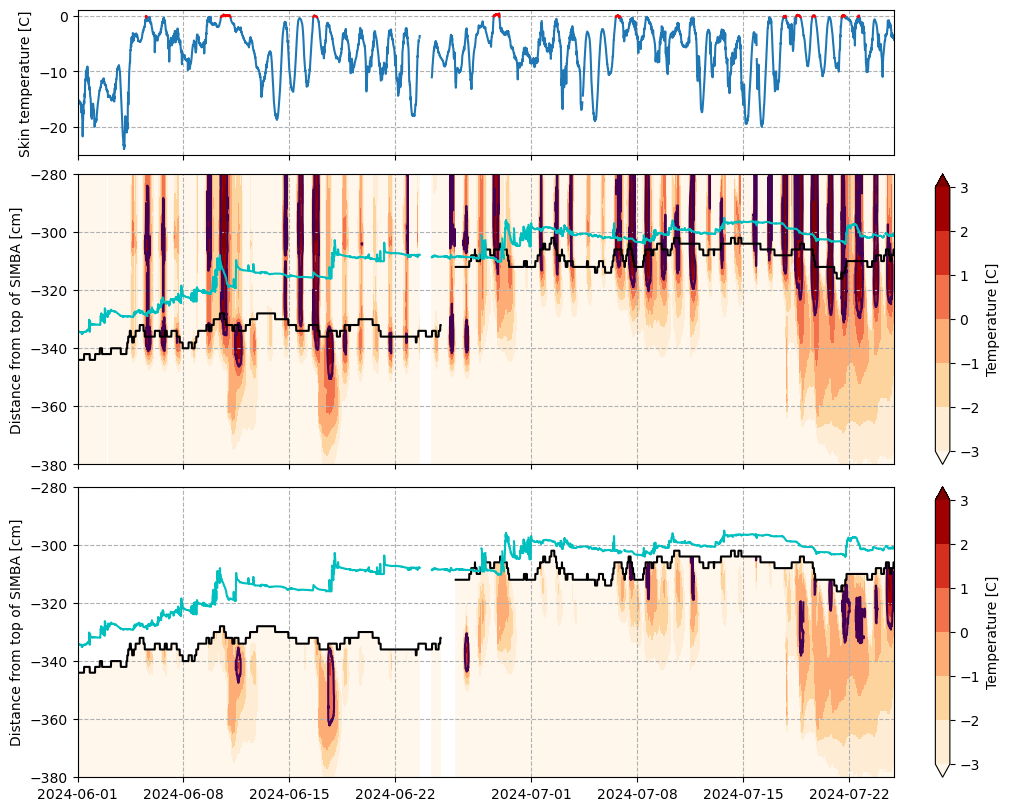

In [48]:
fig, axs = plt.subplots(3, figsize=(10,8), constrained_layout=True, sharex=True, gridspec_kw=dict(height_ratios=[1,2,2]))

axs[0].plot(sleigh_dates, asfs_data_lev2['skin_temp']-273.15)
axs[0].plot(sleigh_dates, np.ma.masked_less(asfs_data_lev2['skin_temp']-273.15, -0.3), c='r')
axs[0].set_ylabel('Skin temperature [C]')

cb = axs[1].contourf(simba_dates, simba_depths, np.swapaxes(season_data['temperature'],0,1),
                cmap=plt.cm.OrRd, levels=np.arange(-3,4,1), extend='both')
axs[1].contour(simba_dates, simba_depths, np.swapaxes(season_data['temperature'],0,1),
                levels=[1], extend='both')
plt.colorbar(cb, ax=axs[1], label='Temperature [C]')

cb = axs[2].contourf(simba_dates, simba_depths, np.swapaxes(corrected_temps,0,1),
                cmap=plt.cm.OrRd, levels=np.arange(-3,4,1), extend='both')
axs[2].contour(simba_dates, simba_depths, np.swapaxes(corrected_temps,0,1),
                levels=[0], extend='both')
plt.colorbar(cb, ax=axs[2], label='Temperature [C]')

for i, ax in enumerate(axs.ravel()):
    ax.grid(ls='--')
    if i>0:
        ax.plot(simba_dates, simba_sfc, c='k')
        ax.plot(sleigh_dates, asfs_data_lev2['snow_depth']-350, c='c')
        ax.set_ylabel('Distance from top of SIMBA [cm]')
        ax.set_ylim(-380, -280)

axs[0].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,7,25))
axs[0].set_ylim(-25,1)

# axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
# plt.savefig('/home/asledd/ICECAPS/keff_retrieval/Raven_dtdz-flux-profile-timeseries_skinT_3level-smoothing-window.png', dpi=250)

plt.show()

Issue I bet David will bring up (because it's true): extinction coefficient can/will be different under melt times than other times!

Should NIR and VIS have seperate extinction coefficients?

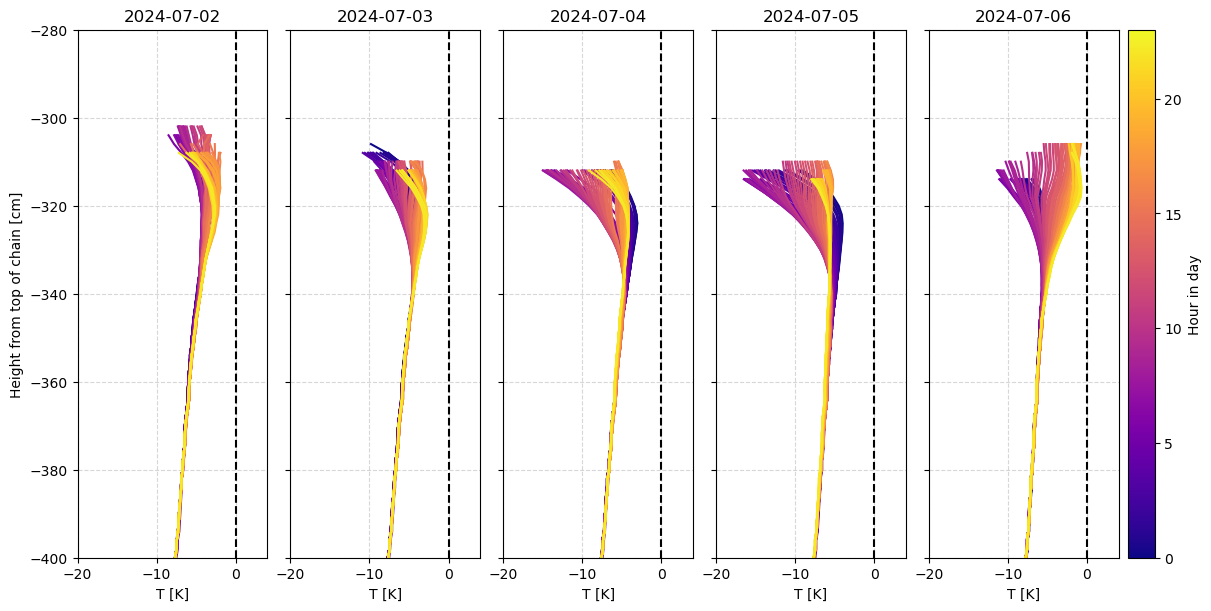

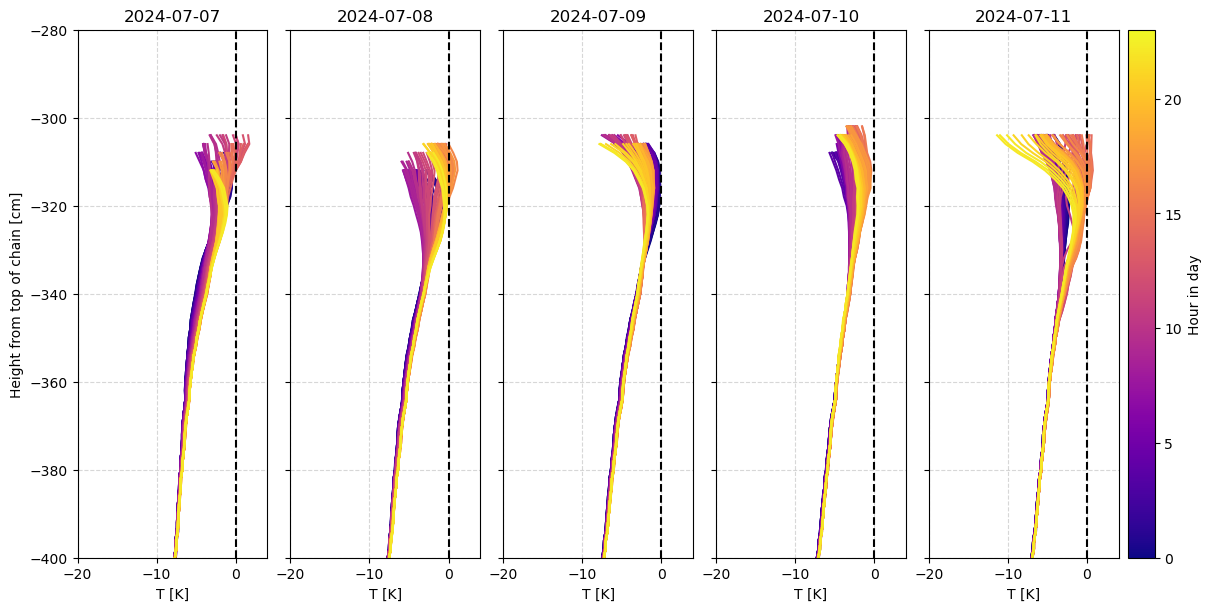

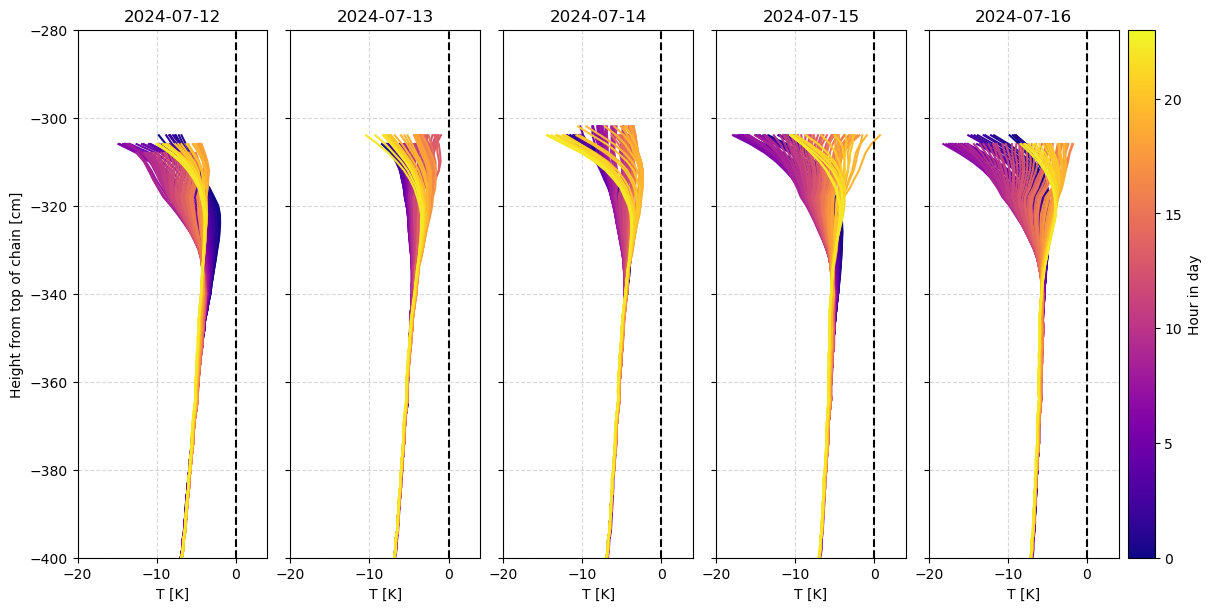

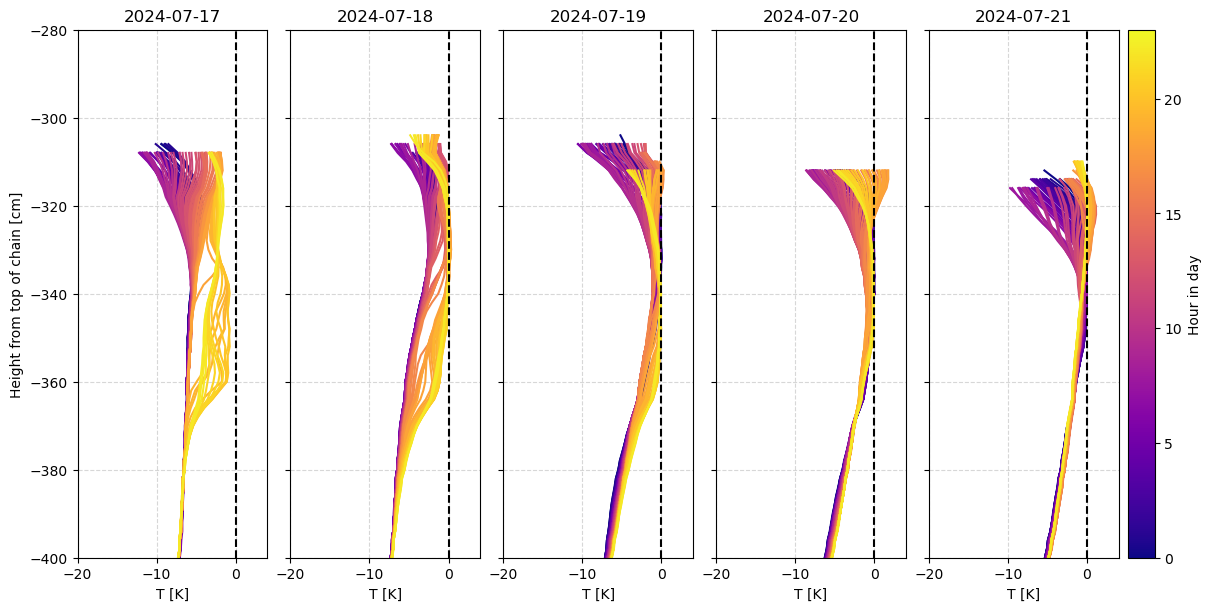

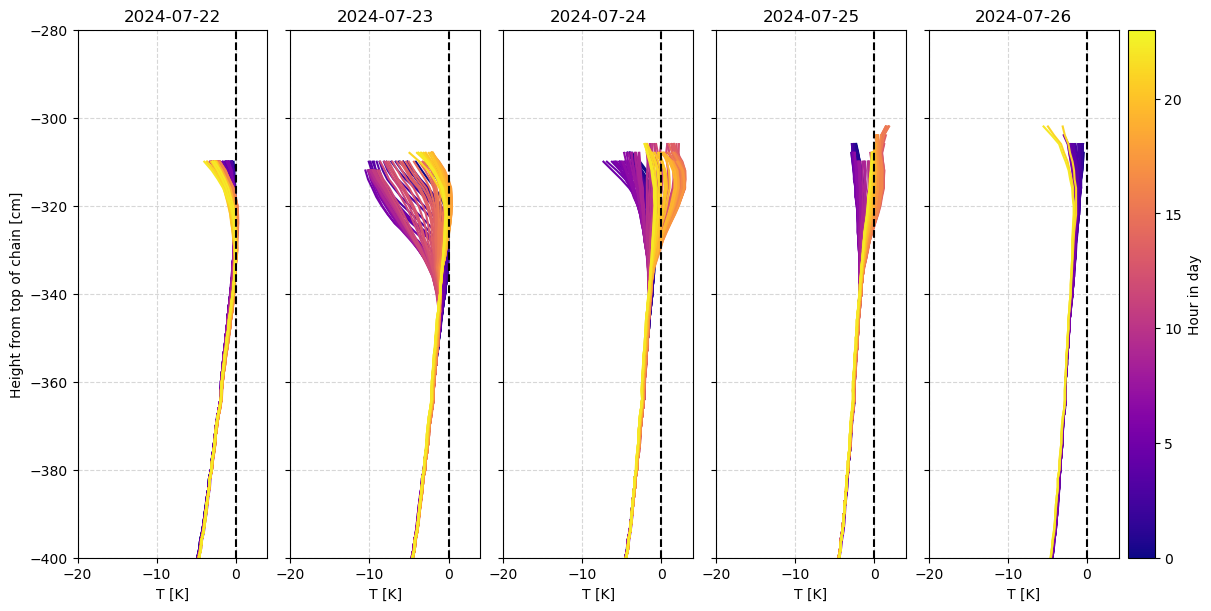

In [352]:
# Look at profiles?

## for june
# for day in range(1,31,5):

## for july
for day in range(1,26,5):
    fig, axs = plt.subplots(1,5, figsize=(12,6), sharey=True, sharex=True, constrained_layout=True)
    axs[0].set_ylabel('Height from top of chain [cm]')
    
    # day = 9
    for ad, ax in zip(range(5), axs.ravel()):
        st_date = datetime.datetime(2024,7,1)+datetime.timedelta(days=day+ad)
        en_date = st_date+datetime.timedelta(days=1)
        figure_date_idx = np.where((np.asarray(simba_dates)>=st_date )&(np.asarray(simba_dates)<en_date ))[0]
        # print(len(figure_date_idx))
        # cbar_ticks = [plt_times[figure_date_idx[idx]] for idx in [0, int(len(figure_date_idx)/2), len(figure_date_idx)-1]]
        cbar_ticks = [0, 12, 23]
        
        for i, t_idx in np.ndenumerate(figure_date_idx[1:]):#[::-1]):
            
            col = plt.cm.plasma(simba_dates[t_idx].hour/24.)
            # print(corrected_temps[t_idx, :])
            ax.plot(np.squeeze(corrected_temps[t_idx, :-1]), simba_depths[:-1], label=t_idx, c=col)#'t=0')
    
        ax.set_xlabel('T [K]')
        ax.grid(alpha=.5, ls='--')
        ax.set_title(st_date.strftime('%Y-%m-%d'))
        ax.axvline(x=0., c='k', ls='--')
        ax.set_xlim(-20, 4)
    axs[0].set_ylim(-400,-280)
    cmappable = ScalarMappable(norm=Normalize(0,23), cmap=plt.cm.plasma)
    
    #colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
    cbar = plt.colorbar(cmappable, label='Hour in day')# ticks=np.arange(0, 23))#
    # cbar.ax.set_yticklabels(cbar_ticks)
    
    # axs[-1].set_xlim(-.1,2)
    # axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'--'+en_date.strftime('%m-%d %H:%M'))
    daystring_st = datetime.datetime(2024,7,day)
    daystring_en = datetime.datetime(2024,7,day+4)
    # filename = 'Raven_temp-height_'+daystring_st.strftime('%Y%m%d-')+daystring_en.strftime('%Y%m%d')+'.png'
    # plt.savefig('/home/asledd/ICECAPS/temperature_profiles/'+filename, dpi=250)
    plt.show()

Suggestions: monte carlo? have three parameters (k_vis, NIR, wind speed, surface?)

get functional form of temperature vs sw vs wind speed

need to have parameters to quantify what's "best": amount of data above 0; difference from skin temperature; 

*talk to chris and david first!


#### Compare temperature corrections and results for the different shapes, given same extinction coefficent/etc

In [50]:
functional_labels = ['Log', 'IHS', 'f(x)=b*x/(a+x)']
funcitonal_corrections = [log_temp_correction, ihs_temp_correction, func_temp_correction]

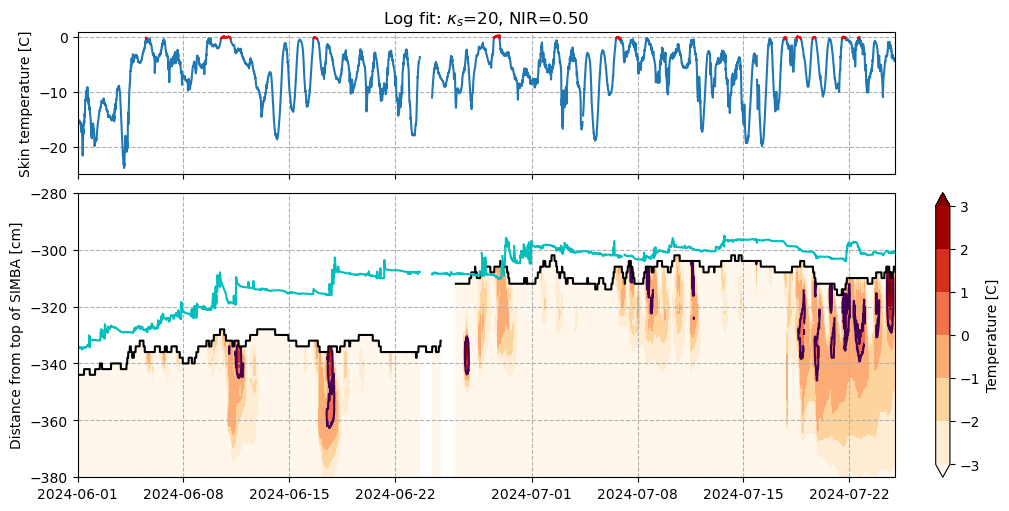

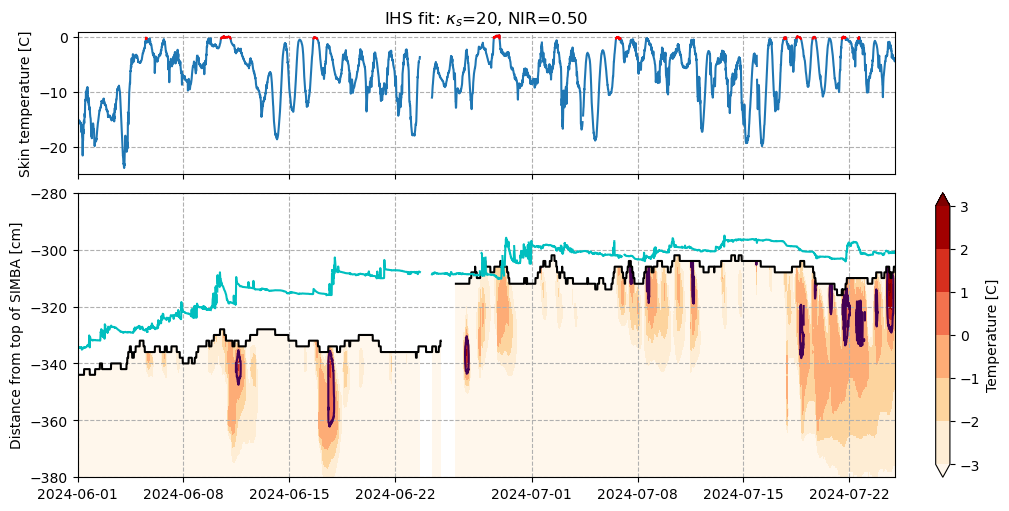

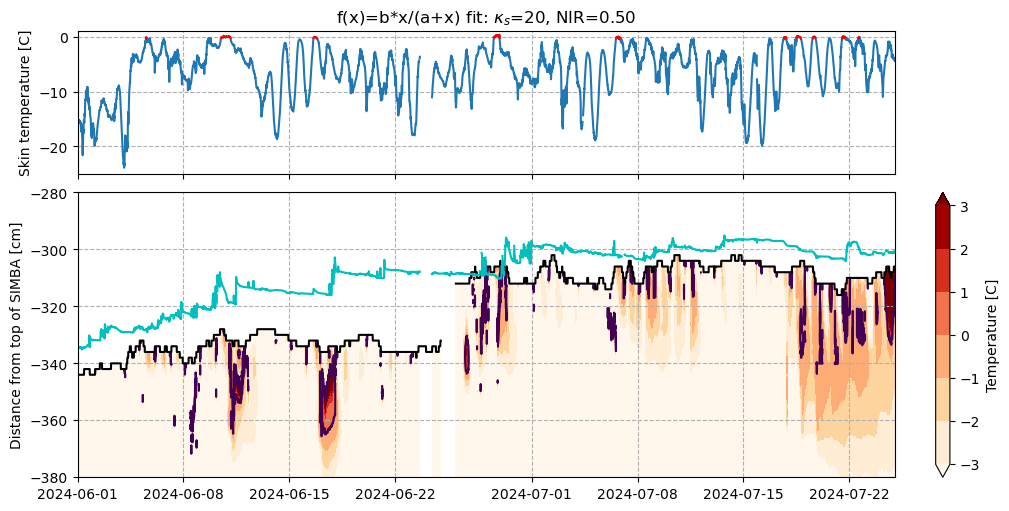

In [51]:
for t_c, label in zip(funcitonal_corrections, functional_labels):

    new_temps = season_data['temperature'] - t_c
    new_temps = np.ma.masked_array(new_temps, mask=simba_swt.mask)
    
    fig, axs = plt.subplots(2, figsize=(10,5), constrained_layout=True, sharex=True, gridspec_kw=dict(height_ratios=[1,2]))
    
    axs[0].plot(sleigh_dates, asfs_data_lev2['skin_temp']-273.15)
    axs[0].plot(sleigh_dates, np.ma.masked_less(asfs_data_lev2['skin_temp']-273.15, -0.3), c='r')
    axs[0].set_ylabel('Skin temperature [C]')
    
    # cb = axs[1].contourf(simba_dates, simba_depths, np.swapaxes(season_data['temperature'],0,1),
    #                 cmap=plt.cm.OrRd, levels=np.arange(-3,4,1), extend='both')
    # axs[1].contour(simba_dates, simba_depths, np.swapaxes(season_data['temperature'],0,1),
    #                 levels=[1], extend='both')
    # plt.colorbar(cb, ax=axs[1], label='Temperature [C]')
    
    cb = axs[1].contourf(simba_dates, simba_depths, np.swapaxes(new_temps,0,1),
                    cmap=plt.cm.OrRd, levels=np.arange(-3,4,1), extend='both')
    axs[1].contour(simba_dates, simba_depths, np.swapaxes(new_temps,0,1),
                    levels=[0], extend='both')
    plt.colorbar(cb, ax=axs[1], label='Temperature [C]')
    
    for i, ax in enumerate(axs.ravel()):
        ax.grid(ls='--')
        if i>0:
            ax.plot(simba_dates, simba_sfc, c='k')
            ax.plot(sleigh_dates, asfs_data_lev2['snow_depth']-350, c='c')
            ax.set_ylabel('Distance from top of SIMBA [cm]')
            ax.set_ylim(-380, -280)
    
    axs[0].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,7,25))
    axs[0].set_ylim(-25,1)
    axs[0].set_title(label+' fit: $\kappa_s$={:.0f}, NIR={:.2f}'.format(ks_vis, 1-nir_frac) )
    # axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
    # plt.savefig('/home/asledd/ICECAPS/keff_retrieval/Raven_dtdz-flux-profile-timeseries_skinT_3level-smoothing-window.png', dpi=250)
    
    plt.show()

## create some summary figures to quantify how well corrections work

In [52]:
## get new surface temperature from SIMBA
sfc_repeat = np.repeat(simba_sfc[:,np.newaxis], season_data['temperature'].shape[1], axis=1)
heights_repeat = np.repeat(simba_depths[np.newaxis,:], season_data['temperature'].shape[0], axis=0)


In [53]:
sfc_seconds = np.repeat(simba_seconds[:,np.newaxis], season_data['height'].shape[0], axis=1)[np.where(heights_repeat==sfc_repeat)]
sfc_dates = np.repeat(simba_dates[:,np.newaxis], season_data['height'].shape[0], axis=1)[np.where(heights_repeat==sfc_repeat)]

In [54]:
## interpolate skin temperature here
sleigh_skin = asfs_data_lev2['skin_temp']
f_0_skinT = interpolate.interp1d(sleigh_seconds[~sleigh_skin.mask], sleigh_skin[~sleigh_skin.mask], fill_value=-999, bounds_error=False)
sleigh_skinT_simba_timesteps = f_0_skinT(sfc_seconds)
sleigh_skinT_simba_timesteps = np.ma.masked_less(sleigh_skinT_simba_timesteps, 0)-273.15


In [55]:
uncorrected_simba_sfc_temp = season_data['temperature'][np.where(heights_repeat==sfc_repeat)]
corrected_simba_sfc_temp = corrected_temps[np.where(heights_repeat==sfc_repeat)]

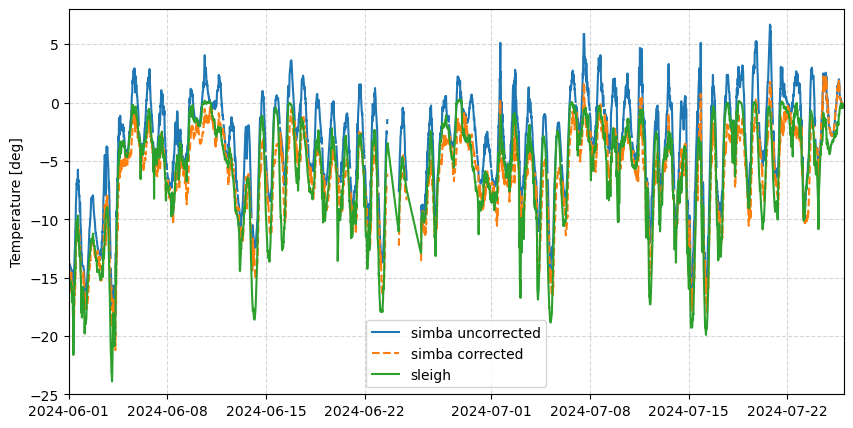

In [56]:
fig, ax = plt.subplots(1, figsize=(10,5))
plt.plot(sfc_dates, uncorrected_simba_sfc_temp, label='simba uncorrected')

plt.plot(sfc_dates, corrected_simba_sfc_temp, label='simba corrected', ls='--')

plt.plot(sfc_dates, sleigh_skinT_simba_timesteps, label='sleigh')

plt.ylabel('Temperature [deg]')
plt.xlim(dt(2024,6,1), dt(2024,7,26))
plt.ylim(-25,8)
plt.grid(alpha=.5, ls='--')
plt.legend(loc='best')
plt.show()

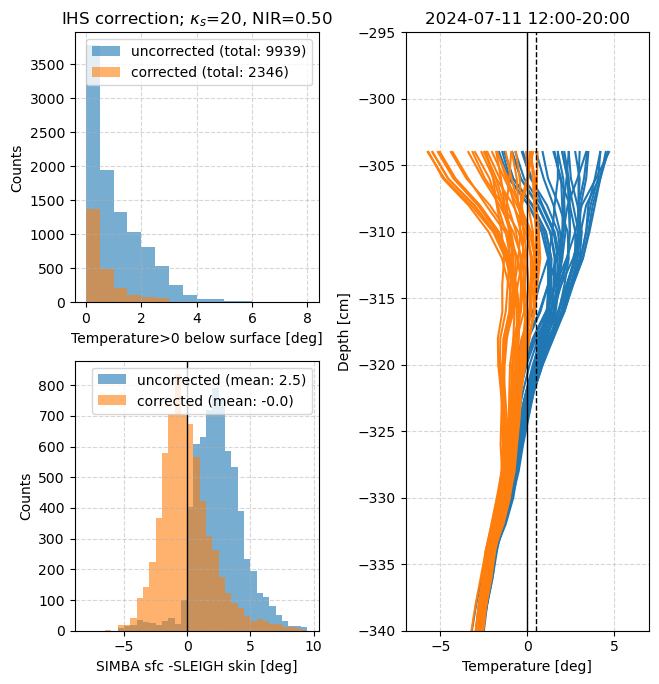

In [57]:
# fig, axs = plt.subplots(1,3, figsize=(9,3), constrained_layout=True)
fig = plt.figure(figsize=(10,10))#, constrained_layout=True)

ax1 = plt.subplot2grid(shape=(3, 3), loc=(1, 0), colspan=1)
ax2 = plt.subplot2grid((3, 3), (2, 0))
ax3 = plt.subplot2grid(shape=(3, 3), loc=(1, 1), rowspan=2)

axs = [ax1, ax2, ax3]

uncorrected_temps = np.ma.masked_array(season_data['temperature'], mask=corrected_temps.mask)
uncorrected_temps_positive = np.ma.masked_less(uncorrected_temps,0)
corrected_temps_positive = np.ma.masked_less(corrected_temps, 0)

bins = np.arange(0,8.01,.5)
axs[0].hist(uncorrected_temps_positive[~uncorrected_temps_positive.mask], alpha=.6, 
            label='uncorrected (total: {:.0f})'.format(uncorrected_temps_positive.count()), bins=bins)
axs[0].hist(corrected_temps_positive[~corrected_temps_positive.mask], alpha=.6, 
            label='corrected (total: {:.0f})'.format(corrected_temps_positive.count()), bins=bins)

axs[0].set_ylabel('Counts')
axs[0].set_xlabel('Temperature>0 below surface [deg]')
axs[0].legend(loc='best')

## HERE/above: corrected skin temperature doesn't have a surface because it was super wonky, so can't test how well it matches; 
## the interpolation for skin temperature is also not working as desired a couple cells above
for simba_var, label in zip([uncorrected_simba_sfc_temp, corrected_simba_sfc_temp], ['uncorrected','corrected']):
    sfc_temp_diff = simba_var - sleigh_skinT_simba_timesteps
    axs[1].hist(sfc_temp_diff[~sfc_temp_diff.mask], alpha=.6, label=label+' (mean: {:.1f})'.format(sfc_temp_diff.mean()),
                bins=np.arange(-8,10,.5))

axs[1].axvline(x=0, c='k', lw=1)
axs[1].set_xlabel('SIMBA sfc -SLEIGH skin [deg]')
axs[1].set_ylabel('Counts')
axs[1].legend(loc='best')


## other good days to check: 717-7/21
for temp_data, c in zip([uncorrected_temps, corrected_temps], ['tab:blue','tab:orange']):
    st_date = dt(2024, 7, 11, 12)
    en_date = dt(2024, 7, 11, 20)
    figure_date_idx = np.where((np.asarray(simba_dates)>=st_date )&(np.asarray(simba_dates)<en_date ))[0]

    for i, t_idx in np.ndenumerate(figure_date_idx[1:]):
        axs[2].plot(np.squeeze(temp_data[t_idx, :-1]), simba_depths[:-1], label=t_idx, c=c)#'t=0')

axs[2].set_xlabel('Temperature [deg]')
axs[2].set_ylabel('Depth [cm]')
axs[2].set_ylim(-340,-295)
axs[2].set_xlim(-7,7)
axs[2].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'-'+en_date.strftime('%H:%M'))
axs[2].axvline(x=0, c='k', lw=1)
axs[2].axvline(x=0.5, c='k', lw=1, ls='--')

for ax in axs:
    ax.grid(ls='--', alpha=.5)
axs[0].set_title('IHS correction; $\kappa_s$={:.0f}, NIR={:.2f}'.format(ks_vis, 1-nir_frac))
# axs[0].set_title('IHS correction; $\kappa_s$={:.0f}->{:.0f}, NIR={:.2f}'.format(ks_st, ks_en, 1-nir_frac))
plt.tight_layout()
plt.show()

# Make a function(s) to cycle through input parameters and compare outcomes!

This is very messy and uses some things that are defined above....

In [58]:
def get_swt_for_correction(sfc_dif, ks, fnir, swn_in, wspd_in):
    # setup sw arrays
    dpths = np.arange(0,.50,.02)
    dpths_2d = np.repeat(dpths[np.newaxis,:], swn_in.shape[0], axis=0)
    simba_swn_2d = np.repeat(swn_in[:,np.newaxis], dpths.shape[0], axis=1)

    simba_swn_2d = np.ma.masked_less(simba_swn_2d, 0)
    simba_wspd_2d = np.repeat(wspd_in[:,np.newaxis], dpths.shape[0], axis=1)

    ## calculate transmitted below surface
    if isinstance(ks, float):
        ks_vis = ks
    else:
        ks_vis = np.linspace(ks[0], ks[1], simba_swn_2d.shape[0])[:,np.newaxis]
        
    sw_abs, sw_trans = calc_sw_ext(simba_swn_2d, ks, dpths_2d, f_nir=fnir)
    sw_trans = np.ma.masked_array(sw_trans, mask=simba_swn_2d.mask)

    
    return sw_trans, simba_wspd_2d

In [59]:
 def get_subsfc_melting_vals(melt_idx_in, swt_in, wspd2_in, sfc_in, sfc_dif):
    sfc_used = sfc_in + sfc_dif
    for idx in melt_idx_in[:]:
        example_profile = season_data['temperature'][imb_idx,:][same_idx_simba,:][idx,:]
    
        idx_sfc = sfc_used[imb_idx][same_idx_simba][idx]
        subsfc_idx = np.where(simba_depths[:-1]<=idx_sfc)[0] ## HERE changed [:-1] to [1:]
        example_profile = np.squeeze(example_profile[subsfc_idx])
        
        too_warm_idx = np.where(example_profile>0)[0]
    
        sw_abs_warm = swt_in[imb_idx,:][same_idx_simba,:][idx,:][too_warm_idx]
        wspd_warm = wspd2_in[imb_idx,:][same_idx_simba,:][idx,:][too_warm_idx]
        temp_warm = example_profile[too_warm_idx]
    
        ## still removing surface value
        if idx==melt_idx[0]:
            all_subsfc_temps_above_f = temp_warm[1:]
            all_subsfc_swabs_above_f = sw_abs_warm[1:]
            all_subsfc_depths_f = simba_depths[:-1][subsfc_idx][too_warm_idx][1:]+abs(idx_sfc)
            all_subsfc_wspd_f = wspd_warm[1:]
        else:
            all_subsfc_temps_above_f = np.ma.concatenate((all_subsfc_temps_above_f, temp_warm[1:]))
            all_subsfc_swabs_above_f = np.ma.concatenate((all_subsfc_swabs_above_f, sw_abs_warm[1:]))
            all_subsfc_depths_f = np.ma.concatenate((all_subsfc_depths_f, simba_depths[:-1][subsfc_idx][too_warm_idx][1:]+abs(idx_sfc)))
            all_subsfc_wspd_f = np.ma.concatenate((all_subsfc_wspd_f, wspd_warm[:-1]))
            
    return all_subsfc_temps_above_f, all_subsfc_swabs_above_f, all_subsfc_depths_f, all_subsfc_wspd_f

In [60]:
def get_ihs_correction(all_subsfc_wspd_in, all_subsfc_swabs_above_in, all_subsfc_temps_above_in, wind_ranges=[0,5,10,25]):
    max_wspd = []
    ihs_vals = []

    ## the sensitivity of these bins should be tested!!!!
    sw_bin_params = {'width0':{15:1, 20:2, 25:1}, 'width1':{15:10, 20:10, 25:15}, 'midpt':{15:15, 20:15, 25:10}}

    for i,(w_lo, w_hi) in enumerate(zip(wind_ranges[:-1],wind_ranges[1:])):

        w_idx = np.where((all_subsfc_wspd_in>=w_lo)&(all_subsfc_wspd_in<w_hi))
        sw_wind = all_subsfc_swabs_above_in[w_idx]
        temp_wind = all_subsfc_temps_above_in[w_idx]

        ## exact choice of percentiles vs max vs whatever can be tested
        bin_xs, bin_ys = get_percentile_bin_vals(sw_wind, temp_wind, bins)
    
        ## force (0,0) point
        bin_xs = np.ma.concatenate( ([0],bin_xs) )
        bin_ys = np.ma.concatenate( ([0],bin_ys) )
    
        bin_xs = np.squeeze(bin_xs[~bin_ys.mask])
        bin_ys = np.squeeze(bin_ys[~bin_ys.mask])

        # IHS fit
        popt, pcov = curve_fit(inverse_hyperbolic_sine, bin_xs, bin_ys)
        
        # Extract the fitted parameter
        theta_fit = popt[0]
        ihs_vals.append(theta_fit)
        max_wspd.append(w_lo)       

    ## now take those curves and generalize to all wind speeds
    ihs_param_wind_regressions = {}

    # save for later
    par = np.polyfit(max_wspd, ihs_vals, 1, full=True)
    ihs_param_wind_regressions['slope'] = par[0][0]
    ihs_param_wind_regressions['intercept'] = par[0][1]

    t, c, k = interpolate.splrep(max_wspd, ihs_vals, k=1)
    spline = interpolate.BSpline(t, c, k, extrapolate=True)
    ihs_param_wind_regressions['spline'] = spline

    return ihs_param_wind_regressions

In [61]:
def calc_temp_corrections(sfc_in, sfc_dif, ks, fnir, correction_params):
    ## differenceing surface here!!!!
    # print(sfc_in)
    sfc_used = sfc_in + sfc_dif
    # print(sfc_used)
    # make simba heights/depths relative to surface
    depths_rel_to_sfc = np.repeat(simba_depths[np.newaxis,:], simba_dates.shape[0], axis=0)
    
    sfc_height_2d = np.repeat(sfc_used[:,np.newaxis], simba_depths.shape[0], axis=1)

    depths_rel_to_sfc = depths_rel_to_sfc + abs(sfc_height_2d)
    depths_rel_to_sfc = np.ma.masked_greater(depths_rel_to_sfc, 0)/100.
    # print(depths_rel_to_sfc)
    # print()
    simba_swn_2d = np.repeat(simba_swn[:,np.newaxis], depths_rel_to_sfc.shape[1], axis=1)

    if isinstance(ks, float):
        ks_vis = ks
    else:
        ks_vis = np.linspace(ks[0], ks[1], simba_swn_2d.shape[0])[:,np.newaxis]
        
    simba_swa, simba_swt = calc_sw_ext(simba_swn_2d, ks_vis, depths_rel_to_sfc, f_nir=fnir)

    # simba_swa = np.ma.masked_array(simba_swa, mask=depths_rel_to_sfc.mask)
    simba_swt = np.ma.masked_array(simba_swt, mask=depths_rel_to_sfc.mask)
    # print(simba_swt.count())
    wspd_2d_full = np.repeat(simba_wspd[:,np.newaxis], simba_swn_2d.shape[1], axis=1)
    wspd_2d_full = np.ma.masked_array(wspd_2d_full, mask=depths_rel_to_sfc.mask)

    ihs_temp_correction = calc_ihs_temp_correct(simba_swt, wspd_2d_full, correction_params, fit='spline')

    return ihs_temp_correction

In [63]:
def correct_compare_temp(temp_corrects, sfc_in, sfc_dif, ks, fnir, fpath):
    sfc_used = sfc_in + sfc_dif
    print(sfc_in)
    print(sfc_used)
    print()
    sfc_repeat = np.repeat(sfc_used[:,np.newaxis], season_data['temperature'].shape[1], axis=1)
    heights_repeat = np.repeat(simba_depths[np.newaxis,:], season_data['temperature'].shape[0], axis=0)
    
    sfc_seconds = np.repeat(simba_seconds[:,np.newaxis], season_data['height'].shape[0], axis=1)[np.where(heights_repeat==sfc_repeat)]

    
    corrected_temps = season_data['temperature'] - temp_corrects
    corrected_temps = np.ma.masked_where(heights_repeat>sfc_repeat, corrected_temps)
    


    ## interpolate skin temperature here
    sleigh_skin = asfs_data_lev2['skin_temp']
    f_0_skinT = interpolate.interp1d(sleigh_seconds[~sleigh_skin.mask], sleigh_skin[~sleigh_skin.mask], fill_value=-999, bounds_error=False)
    sleigh_skinT_simba_timesteps = f_0_skinT(sfc_seconds)
    sleigh_skinT_simba_timesteps = np.ma.masked_less(sleigh_skinT_simba_timesteps, 0)-273.15

    uncorrected_simba_sfc_temp = season_data['temperature'][np.where(heights_repeat==sfc_repeat)]
    corrected_simba_sfc_temp = corrected_temps[np.where(heights_repeat==sfc_repeat)]


    ## summary figure here
    ## for comparisons
    output_summary = {'ts_diff_mean':{},'ts_diff_min':{},'ts_diff_max':{}, 'above_zero_count':{}, 'above_0.5_count':{}}

    fig = plt.figure(figsize=(7,7), constrained_layout=True)
    
    ax1 = plt.subplot2grid(shape=(2,2), loc=(0, 0), colspan=1)
    ax2 = plt.subplot2grid((2,2), (1, 0))
    ax3 = plt.subplot2grid(shape=(2,2), loc=(0, 1), rowspan=2)
    
    axs = [ax1, ax2, ax3]
    
    uncorrected_temps = np.ma.masked_array(season_data['temperature'], mask=corrected_temps.mask)
    uncorrected_temps_positive = np.ma.masked_less(uncorrected_temps,0)
    corrected_temps_positive = np.ma.masked_less(corrected_temps, 0)
    uncorrected_temps_positive_uncert = np.ma.masked_less(uncorrected_temps,0.5)
    corrected_temps_positive_uncert = np.ma.masked_less(corrected_temps,0.5)

    for simba_var, label in zip([uncorrected_temps_positive_uncert, corrected_temps_positive_uncert], ['uncorrected','corrected']):
        output_summary['above_0.5_count'][label] = simba_var.count()

    bins = np.arange(0,8.01,.5)
    for simba_var, label in zip([uncorrected_temps_positive, corrected_temps_positive], ['uncorrected','corrected']):

        axs[0].hist(simba_var[~simba_var.mask], alpha=.6, 
                label=label+' (total: {:.0f})'.format(simba_var.count()), bins=bins)
        output_summary['above_zero_count'][label] = simba_var.count()

    axs[0].set_ylabel('Counts')
    axs[0].set_xlabel('Temperature>0 below surface [deg]')
    axs[0].legend(loc='best')

    
    for simba_var, label in zip([uncorrected_simba_sfc_temp, corrected_simba_sfc_temp], ['uncorrected','corrected']):
        sfc_temp_diff = simba_var - sleigh_skinT_simba_timesteps
        # print(label, sfc_temp_diff)
        output_summary['ts_diff_mean'][label] = sfc_temp_diff.mean()
        output_summary['ts_diff_min'][label] = sfc_temp_diff.min()
        output_summary['ts_diff_max'][label] = sfc_temp_diff.max()

        axs[1].hist(sfc_temp_diff[~sfc_temp_diff.mask], alpha=.6, label=label+' (mean: {:.1f})'.format(sfc_temp_diff.mean()),
                    bins=np.arange(-8,10,.5))
    
    axs[1].axvline(x=0, c='k', lw=1)
    axs[1].set_xlabel('SIMBA sfc -SLEIGH skin [deg]')
    axs[1].set_ylabel('Counts')
    axs[1].legend(loc='best')
    
    
    ## other good days to check: 717-7/21
    for temp_data, c in zip([uncorrected_temps, corrected_temps], ['tab:blue','tab:orange']):
        st_date = dt(2024, 7, 11, 12)
        en_date = dt(2024, 7, 11, 20)
        figure_date_idx = np.where((np.asarray(simba_dates)>=st_date )&(np.asarray(simba_dates)<en_date ))[0]
    
        for i, t_idx in np.ndenumerate(figure_date_idx[1:]):
            axs[2].plot(np.squeeze(temp_data[t_idx, :-1]), simba_depths[:-1], label=t_idx, c=c)#'t=0')
    
    axs[2].set_xlabel('Temperature [deg]')
    axs[2].set_ylabel('Depth [cm]')
    axs[2].set_ylim(-340,-295)
    axs[2].set_xlim(-7,7)
    axs[2].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'-'+en_date.strftime('%H:%M'))
    axs[2].axvline(x=0, c='k', lw=1)
    axs[2].axvline(x=0.5, c='k', lw=1, ls='--')
    
    for ax in axs:
        ax.grid(ls='--', alpha=.5)
    
    axs[0].set_title('$\kappa_s$={:.0f}, NIR={:.2f}, $\Delta$ sfc={:.0f}cm'.format(ks, 1-fnir, sfc_dif))
    # plt.tight_layout()
    fname = 'Raven_SIMBA_SW-correction_summary_IHS_{:.0f}ks_{:.2f}NIR_{:.0f}sfc_spline.png'.format(ks, 1-fnir, sfc_dif)
    # plt.savefig(fpath+fname, dpi=200)
    plt.show()
    plt.close()
    # plt.save()
    
    return output_summary

Try putting it all together...

In [64]:
mc_fig_savepath = '/home/asledd/ICECAPS/simba_solar_correction_mc_figures/'

In [65]:
swn = asfs_data_lev2['net_short_hemisp']
f_swn = interpolate.interp1d(sleigh_seconds[~swn.mask], swn[~swn.mask], fill_value=-999, bounds_error=False)

f_ws = interpolate.interp1d(sleigh_seconds[~wind_spd.mask], wind_spd[~wind_spd.mask], fill_value=-999, bounds_error=False)

In [306]:
print(simba_sfc)

[-- -- -- ... -348.0 -348.0 -348.0]


15 -6.0 0.4


/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


[-- -- -- ... -348.0 -348.0 -348.0]
[-- -- -- ... -354.0 -354.0 -354.0]



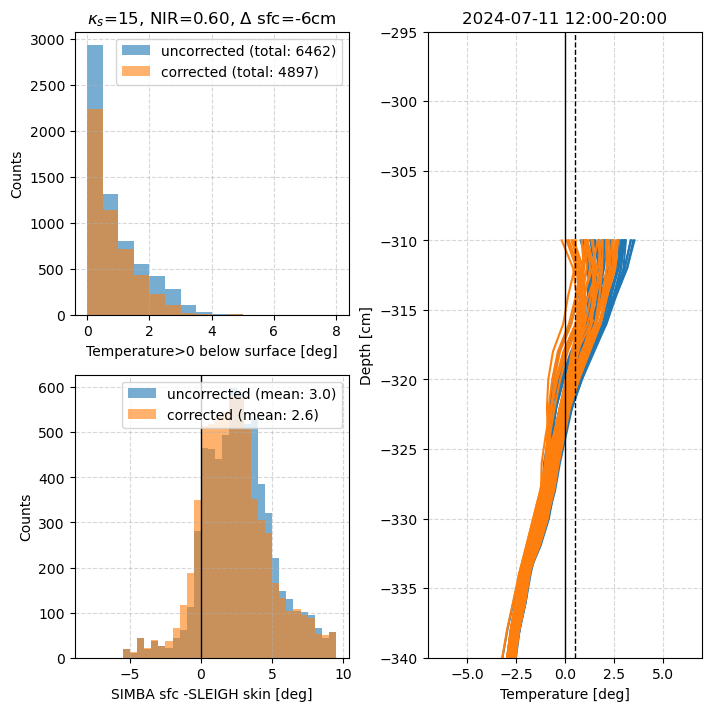

15 -6.0 0.5


/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


[-- -- -- ... -348.0 -348.0 -348.0]
[-- -- -- ... -354.0 -354.0 -354.0]



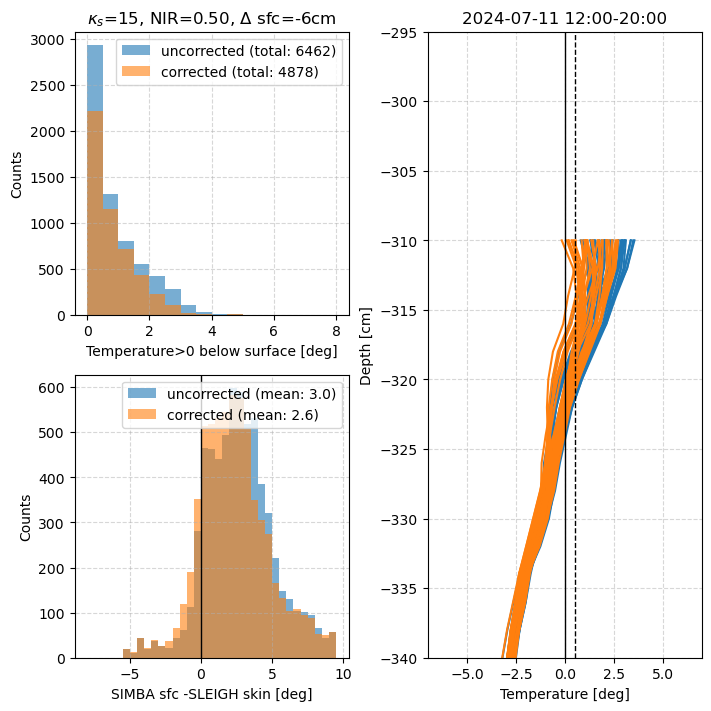

15 -6.0 0.6


/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


TypeError: object of type 'numpy.float64' has no len()

In [66]:
# ks_i = 20.
# sfc_dif_i = 0.
# fnir_i = 0.5

all_summary_values = {}
# fnir_i = 0.5
# ks_i = 20
for ks_i in np.arange(15,41,5):
    for sfc_dif_i in np.arange(-6,0.01,2):
        for fnir_i in np.arange(.4,.601,.1):
            print(ks_i,sfc_dif_i,fnir_i)
            

            simba_swn = f_swn(simba_seconds)
            simba_swn = np.ma.masked_equal(simba_swn, -999)
            
            simba_wspd = f_ws(simba_seconds)
            simba_wspd = np.ma.masked_equal(simba_wspd, -999)

            swt_out, wspd_2d_out = get_swt_for_correction(sfc_dif_i, float(ks_i), fnir_i, simba_swn, simba_wspd)
            sub_temps_above_out, sub_swabs_above_out, sub_depths_out, sub_wspd_out = get_subsfc_melting_vals(melt_idx, swt_out, wspd_2d_out, simba_sfc_heights, sfc_dif_i)
            
            ihs_params = get_ihs_correction(sub_wspd_out, sub_swabs_above_out, sub_temps_above_out, wind_ranges=[0,5,10,25])
            
            temp_correction_out = calc_temp_corrections(simba_sfc, sfc_dif_i, float(ks_i), fnir_i, ihs_params)
            # print(temp_correction_out)
            mc_summary_vals = correct_compare_temp(temp_correction_out, simba_sfc, sfc_dif_i, ks_i, fnir_i, mc_fig_savepath)
            
            all_summary_values[(sfc_dif_i, ks_i, fnir_i)] = mc_summary_vals
            # print()

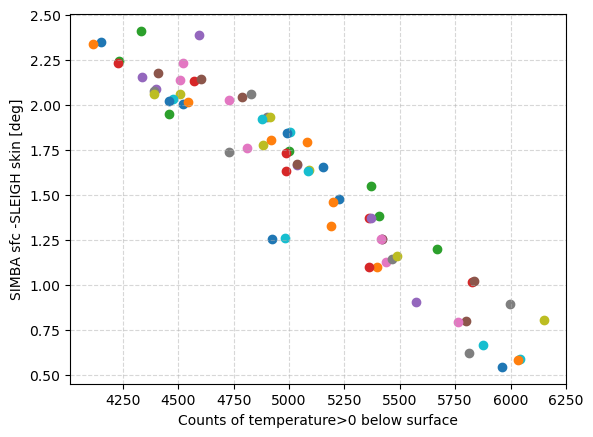

In [311]:
for key in all_summary_values:
    if np.ma.is_masked(all_summary_values[key]['above_zero_count']['corrected']) or np.ma.is_masked(all_summary_values[key]['ts_diff_mean']['corrected']):
        continue
    plt.scatter(all_summary_values[key]['above_zero_count']['corrected'], all_summary_values[key]['ts_diff_mean']['corrected'])

plt.ylabel('SIMBA sfc -SLEIGH skin [deg]')
plt.xlabel('Counts of temperature>0 below surface')
plt.grid(alpha=.5, ls='--')
# plt.xlim(250,300)
plt.show()

Turn all_summary_values be saved as/turned into arrays

In [295]:
print(all_summary_values[key].keys())

dict_keys(['ts_diff_mean', 'ts_diff_min', 'ts_diff_max', 'above_zero_count', 'above_0.5_count'])


In [296]:
summary_varnames = ['ts_diff_mean', 'ts_diff_min', 'ts_diff_max', 'above_zero_count']

In [297]:
summary_arrays_corrected = {}
summary_arrays_uncorrected = {}
input_variables = {}

In [298]:
for varname in summary_varnames:
    var_array_corrected = np.array([ all_summary_values[key][varname]['corrected'] for key in all_summary_values] )
    var_array_uncorrected = np.array([ all_summary_values[key][varname]['uncorrected'] for key in all_summary_values] )

    summary_arrays_corrected[varname] = np.ma.masked_invalid(var_array_corrected)
    summary_arrays_uncorrected[varname] = np.ma.masked_invalid(var_array_uncorrected)

# (sfc_dif_i, ks_i, fnir_i)
summary_arrays_corrected['ts_diff_range'] = summary_arrays_corrected['ts_diff_max'] - summary_arrays_corrected['ts_diff_min']
pos_count_difference = summary_arrays_corrected['above_zero_count'] - summary_arrays_uncorrected['above_zero_count']

sfc_differences = np.array([ key[0] for key in all_summary_values] )
extinction_coefficients = np.array([ key[1] for key in all_summary_values] )
nir_fractions = np.array([ key[2] for key in all_summary_values] )


In [299]:
for key in all_summary_values:
    print(all_summary_values[key]['ts_diff_mean']['corrected'], all_summary_values[key]['ts_diff_min']['corrected'], all_summary_values[key]['ts_diff_max']['corrected'])

2.348100063870917 -5.336819173466155 16.31053692225637
2.337588681267761 -5.336823512262979 16.31104392789424
2.4103454681411023 -5.336373714875504 16.306007879020864
2.1324460655434208 -5.33761683934224 14.818856797431572
2.0859095930886853 -5.337914713828076 14.814457968335155
2.1434441143667984 -5.337461683712539 14.815041038629372
1.7616705994823896 -5.213829926890508 13.846215161276259
1.7397043127709706 -5.214399884550707 13.844772721739504
1.7771103556219712 -5.214043325951197 13.845675092474501
1.26137431546481 -5.153449521240071 13.090851024731055
1.2556137981981783 -5.153743281645317 13.090107618483536
1.326265726463651 -5.157122370564904 13.088936432473822
2.2427247837657536 -5.449666615582199 16.309022217464513
2.2330633536054396 -5.402509980510779 16.302484990793857
2.385663179523737 -5.336325794636973 16.30515742050448
2.0420628973210624 -5.3377009884804085 14.806490888393375
2.0241148929956356 -5.337961463124386 14.804805657217381
2.0595572127897404 -5.337552463792756 14

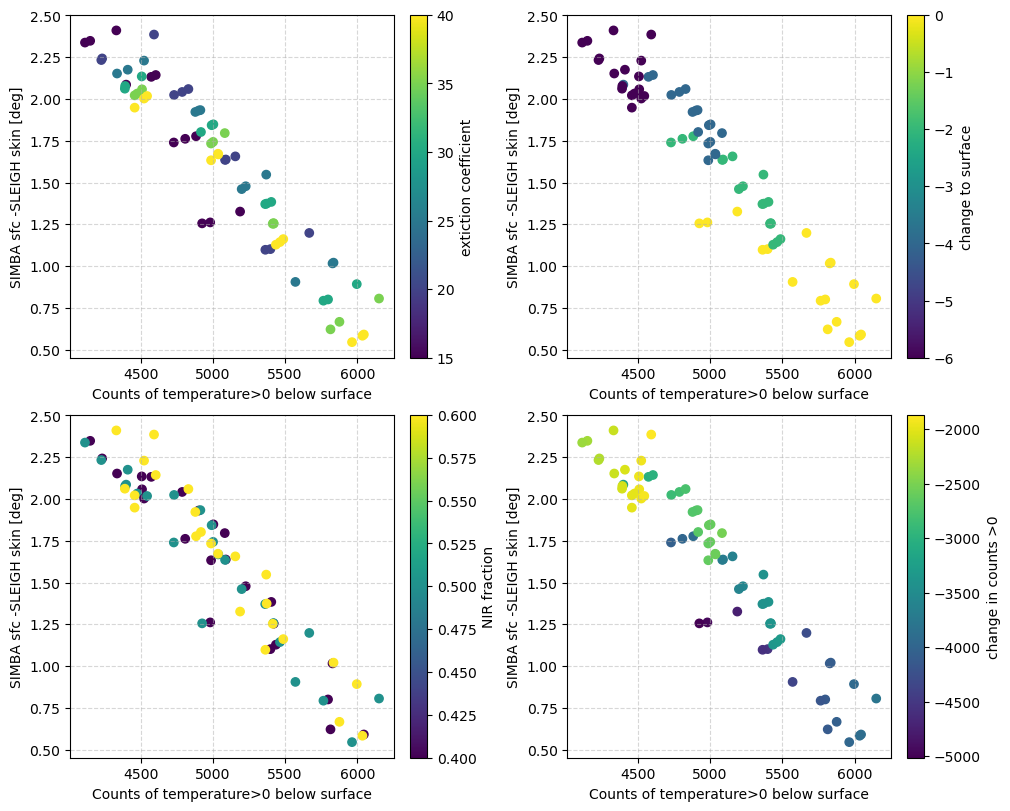

In [300]:
names = ['extiction coefficient','change to surface','NIR fraction','change in counts >0']
cvars = [extinction_coefficients,sfc_differences,nir_fractions,pos_count_difference]

fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(10,8))

for cname,cvar, ax in zip(names,cvars, axs.ravel()):
    cb = ax.scatter(summary_arrays_corrected['above_zero_count'], summary_arrays_corrected['ts_diff_mean'], c=cvar)
    # plt.errorbar(summary_arrays_corrected['above_zero_count'], summary_arrays_corrected['ts_diff_mean'], 
    #              np.array([summary_arrays_corrected['ts_diff_min'], summary_arrays_corrected['ts_diff_max']]), fmt='r^')
    
    
    plt.colorbar(cb, label=cname, ax=ax)

    ax.set_ylabel('SIMBA sfc -SLEIGH skin [deg]')
    ax.set_xlabel('Counts of temperature>0 below surface')
    ax.grid(alpha=.5, ls='--')
# plt.savefig('Raven_SIMBA_solar-correction_linear-IHS-theta-fit_ks-sfc-fnir_mc.png', dpi=200)
plt.show()